# Civilian Transportation Impacts and Proximity U.S. Military Bases

Sophie McDowall (Georgetown University Masters in Data Science and Analytics)  
December 19, 2025

United States airline traffic has been significantly disrupted this year due to personnel cuts and the government shutdown. Aviation is critical for transportation and continuity of supply chain functioning. Civilian infrastructure also underpins the ability of the U.S. military to mobilize forces. In my analysis, I will use BTS airline delay data to identify relationships between commercial air traffic delays and aviation incidents and their proximity to U.S. military bases. Through this analysis, I aim to understand the trends surrounding aviation near military bases including trends in incident occurence rates and commercial flight delay impacts.

In [ ]:
# packages
library(tidyverse) |> suppressPackageStartupMessages()
library(sf) |> suppressPackageStartupMessages()
library(mapview) |> suppressPackageStartupMessages()
library(spatstat) |> suppressPackageStartupMessages()
library(jsonlite) |> suppressPackageStartupMessages()
library(lubridate) |> suppressPackageStartupMessages()
library(rnaturalearth) |> suppressPackageStartupMessages()
library(ggplot2) |> suppressPackageStartupMessages()
library(tibble) |> suppressPackageStartupMessages()
library(spatstat.geom) |> suppressPackageStartupMessages()
library(webshot2) |> suppressPackageStartupMessages()
library(dplyr) |> suppressPackageStartupMessages()

## 0.1 Introduction

The U.S. military relies on civilian infrastructure including highways, seaports, and airports to mobilize in the case of a national emergency or wartime. This research seeks to understand potential relationships between transportation incidents (accidents and delays) and proximity to military base, especially whether the length or likelihood of airline delays has any relation to military base proximity.

1.  **Are there more or less transportation incidents near military bases?**
2.  **How does proximity to military bases impact delays at civilian airports?**

## 0.2 Datasets

| Dataset | Source | Format | Link |
|----|----|----|----|
| Military Bases (geoJSON) | DOT Bureau of Transportation Statistics | Multipolygon | <https://data-usdot.opendata.arcgis.com/datasets/usdot::military-bases/about> |
| Transportation Incidents (JSON) | National Transportation Safety Board | Point | <https://data.ntsb.gov/carol-main-public/basic-search> |
| Airline Delays (CSV) | DOT Bureau of Transportation Statistics | Point - Needs geodata for airports | <https://www.transtats.bts.gov/ot_delay/OT_DelayCause1.asp?20=E> |
| Airport Location (CSV) | DOT Bureau of Transportation Statistics | Point | <https://geodata.bts.gov/datasets/usdot::aviation-facilities/explore> |

In [ ]:
# Load base data and visualize
bases_sf <- st_read("data/raw/military_bases.geojson")

Reading layer `military_bases' from data source 
  `/home/jupyter-svm37/dsan6750final/data/raw/military_bases.geojson' 
  using driver `GeoJSON'
Simple feature collection with 824 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -168.0131 ymin: 13.30911 xmax: 174.1565 ymax: 71.34432
Geodetic CRS:  WGS 84

all geometries

all geometries

all geometries

all geometries

# 1. Question 1: Are there more or less transportation incidents near military bases?

## 1.1 Approach

In order to answer Question 1, I used data on the locations of U.S. military bases from the Department of Transportation and data on transportation incidents from the National Transportation Safety Board. After cleaning and combining the data as necessary for map visualizations and comparisons, I visualized the locations of bases and aviation incidents as shown in Figure 1. I excluded Alaska, Hawaii, and U.S. territories to focus only on the continental United States.

To understand the makeup and initial trends in the data, I did basic exploratory data analysis for all of the data and for only aviation incidents with injuries.

### 1.1.1 Basic Dataset Statistics - All Incidents

#### 1.1.1.1 Temporal Visualization - All Incidents

By visualizing the temporal nature of the data, incident patterns or lack thereof can be identified. For all incidents, there has been a slight decline in number in recent years vs. the previoius five years, but this is also based on incomplete data for 2025. When looking at monthly trends, there is a much higher number of reported incidents in the summer months. This could be due to higher rates of travel, although it would seem that winter months are more dangerous in terms of weather conditions. This may lead to greater caution by operators.

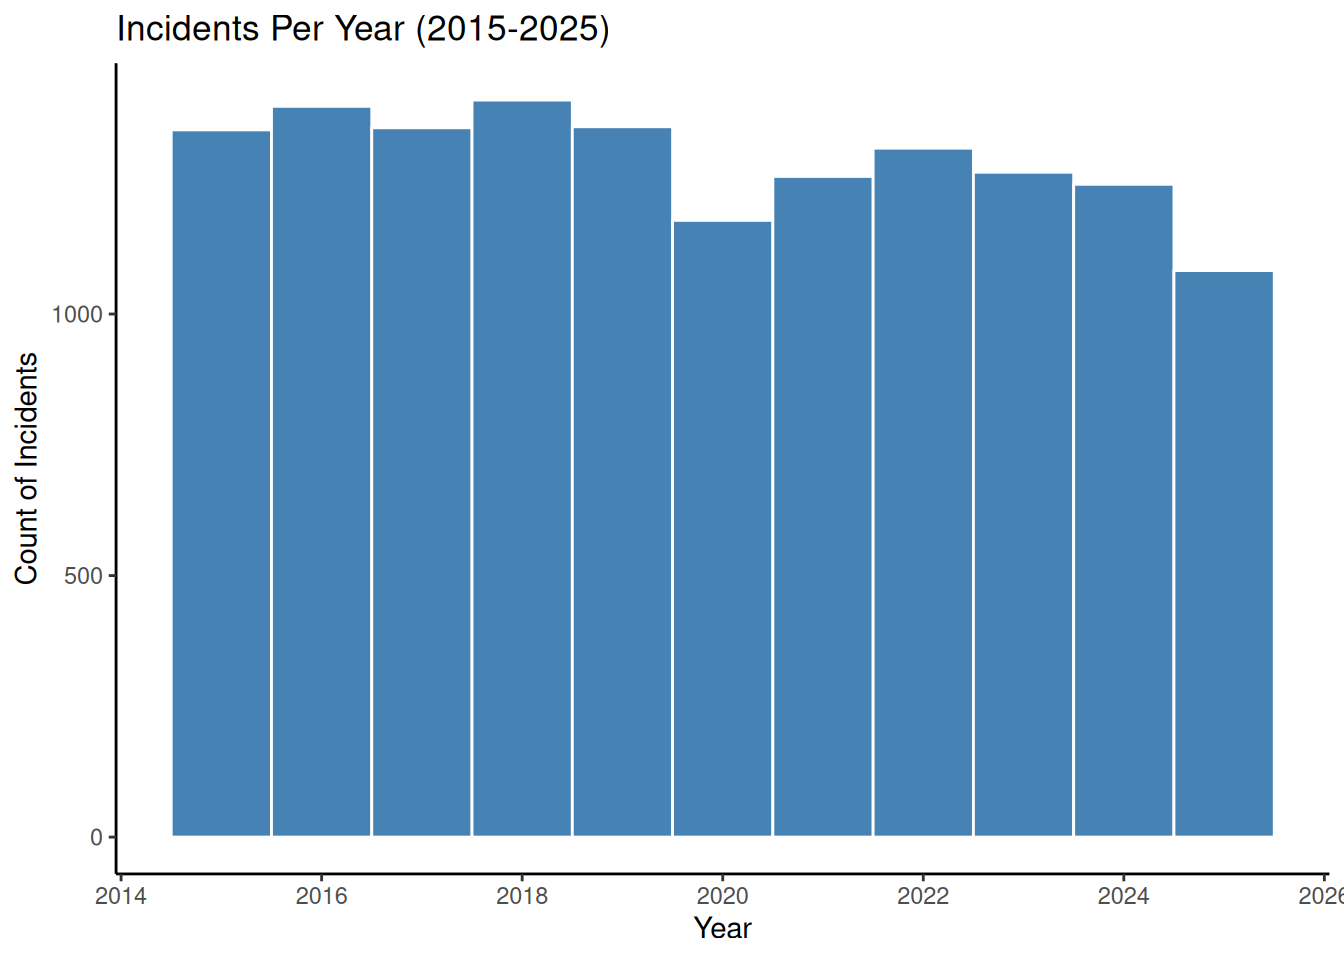

In [ ]:
# date time conversion/columns
 all_data_dates <- all_data_clean |>
    mutate(
        event_date = ymd_hms(cm_eventDate),
        event_year = year(event_date),
        event_month = month(event_date, label = TRUE, abbr = TRUE)
    )

# histogram by year
ggplot(all_data_dates, aes(x = event_year)) +
  geom_histogram(binwidth = 1, fill = "steelblue", color = "white") +
  theme_classic() +
  labs(
    title = "Incidents Per Year (2015-2025)",
    x = "Year",
    y = "Count of Incidents"
  )

Figure 1: Histogram of Incidents by Year from 2015-2025

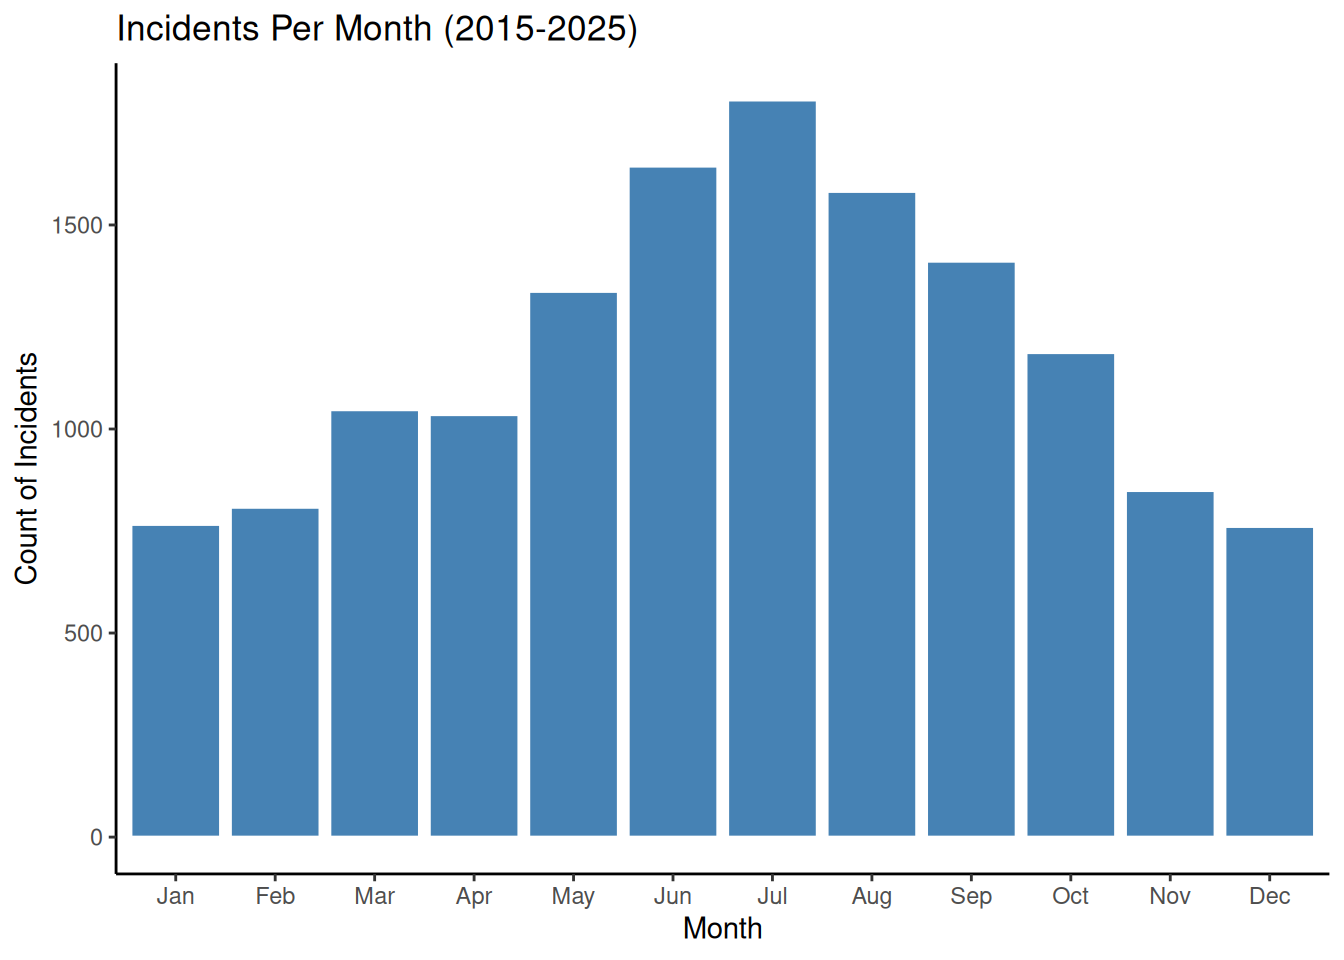

In [ ]:
# histogram by month 
ggplot(all_data_dates, aes(x = event_month)) +
  geom_bar(fill = "steelblue", color = "white") +
  theme_classic() +
  labs(
    title = "Incidents Per Month (2015-2025)",
    x = "Month",
    y = "Count of Incidents"
  )

Figure 2: Monthly Distribution of Incidents for 2015-2025

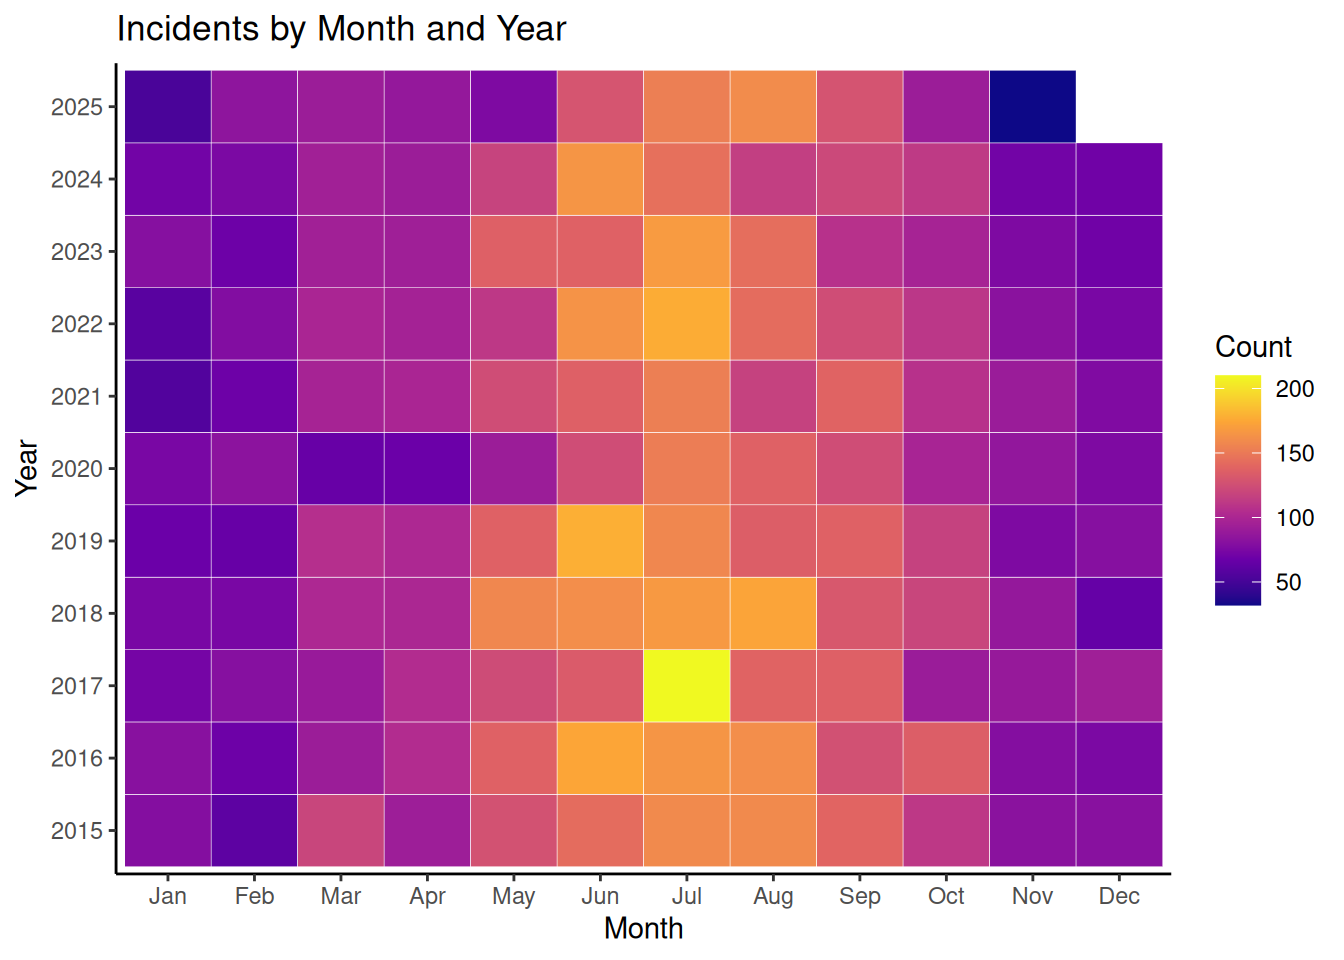

In [ ]:
# heat map by year and month 
all_data_dates %>%
  count(event_year, event_month) |>
  ggplot(aes(x = event_month, y = factor(event_year), fill = n)) +
  geom_tile(color = "white") +
  scale_fill_viridis_c(option = "C") +
  labs(
    title = "Incidents by Month and Year",
    x = "Month",
    y = "Year",
    fill = "Count"
  ) +
  theme_classic()

Figure 3: Heatmap distribution of monthly incidents by year. July 2017 saw the most incidents reported.

#### 1.1.1.2 Incidents by Type - All Incidents

   cm_mode     n
1 Aviation 13656
2   Marine   335
3  Highway   113
4 Railroad   109
5 Pipeline    17
6   Hazmat     3

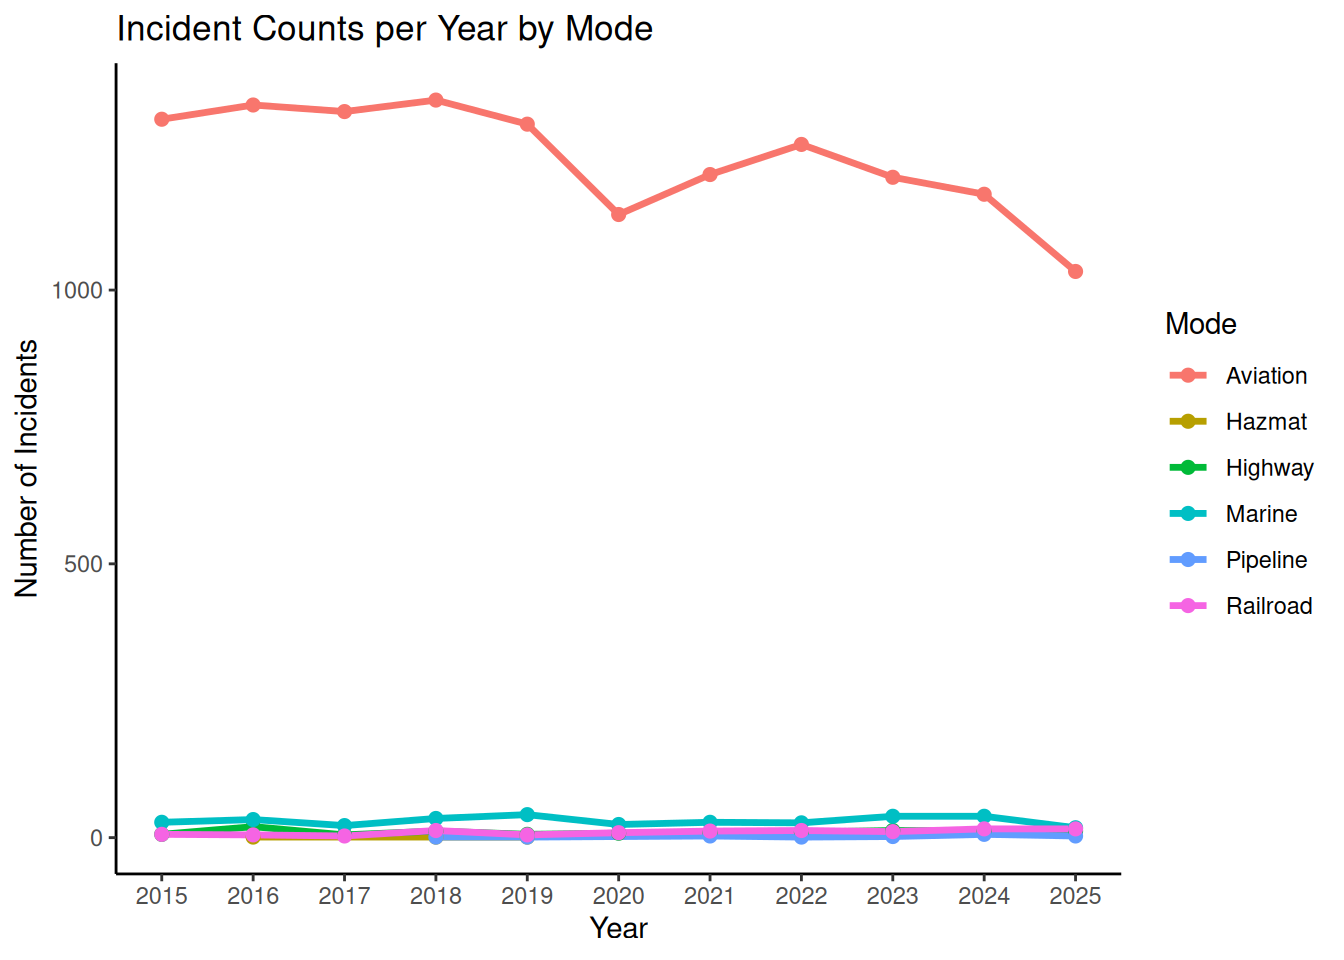

In [ ]:
all_data_clean |>
  count(cm_mode) |>
  arrange(desc(n))

Figure 4: Line plot of temporal trends in incident count by Mode. Aviation incidents account for the vast majority of incidents reported.

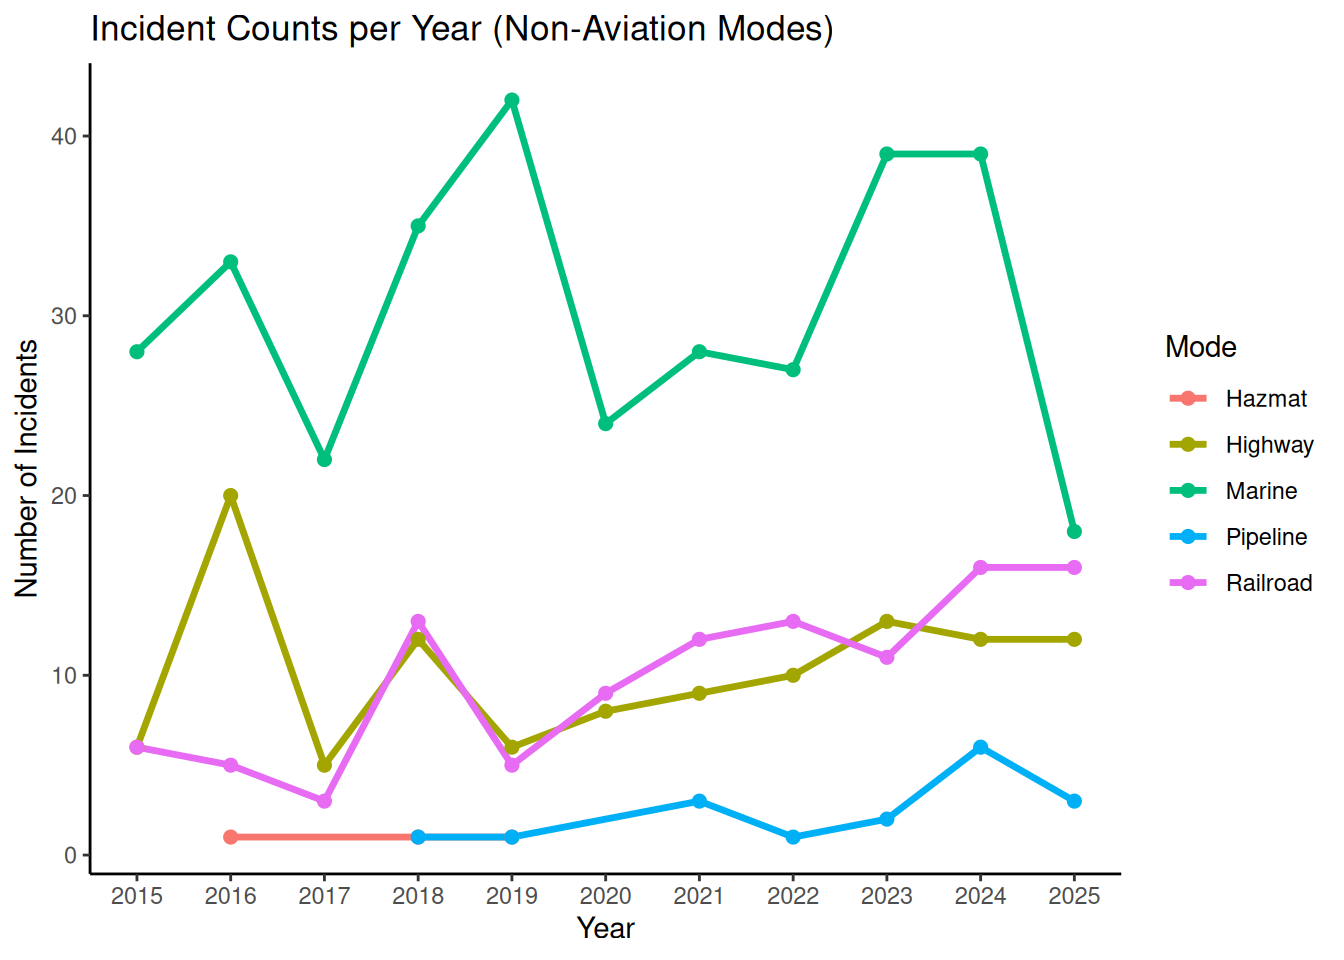

In [ ]:
# non-aviation
ggplot(
  filter(year_mode_counts, cm_mode != "Aviation"),
  aes(x = event_year, y = count, color = cm_mode)
) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 2) +
  theme_classic() +
  labs(
    title = "Incident Counts per Year (Non-Aviation Modes)",
    x = "Year",
    y = "Number of Incidents",
    color = "Mode"
  ) +
  scale_x_continuous(breaks = unique(year_mode_counts$event_year))

Figure 4: Line plot of temporal trends in incident count by Mode, excluding aviation for more minute visual of other modes.

  cm_highestInjury    n
1             None 7859
2            Fatal 2482
3            Minor 2159
4          Serious 1733

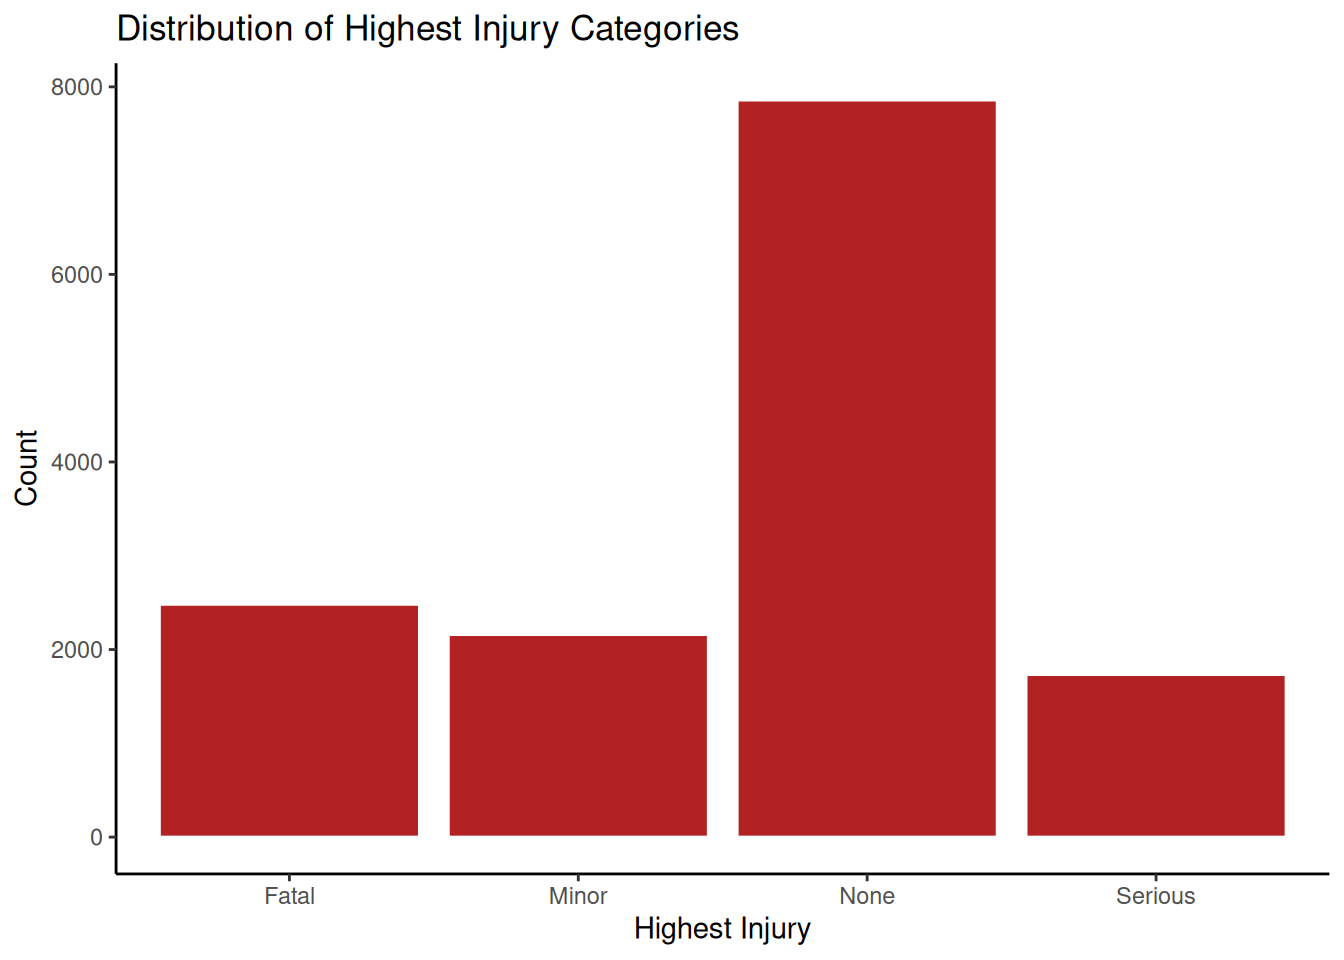

In [ ]:
# Categories
all_data_clean |>
  count(cm_highestInjury) |>
  arrange(desc(n))

Figure 5: Counts of Incidents by Injury Type

### 1.1.2 Basic Dataset Statistics - Only Incidents with Injuries

Based on the high number of incidents without injuries, the following plots narrow the focus to only incidents that had any level of injury reported.

#### 1.1.2.1 Temporal Visualization - Incidents with Injuries

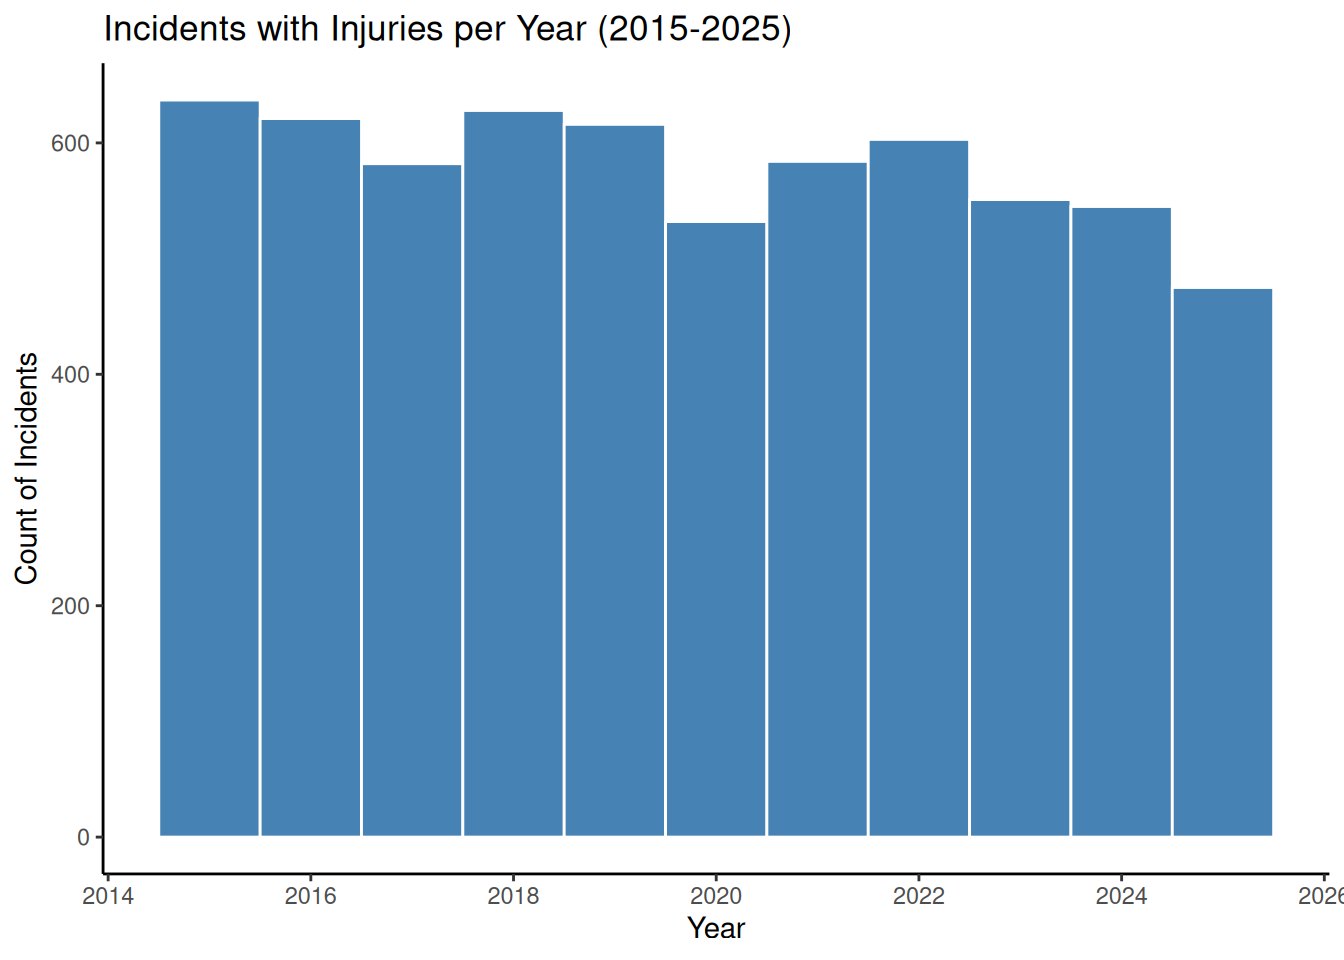

In [ ]:
# Excluding non injury incidents

# injury conversions
injury_df <- all_data_dates |>
  filter(cm_highestInjury != "None")

# histogram by year
ggplot(injury_df, aes(x = event_year)) +
  geom_histogram(binwidth = 1, fill = "steelblue", color = "white") +
  theme_classic() +
  labs(
    title = "Incidents with Injuries per Year (2015-2025)",
    x = "Year",
    y = "Count of Incidents"
  )

Figure 6: Histogram of Incidents with Injuries by Year from 2015-2025

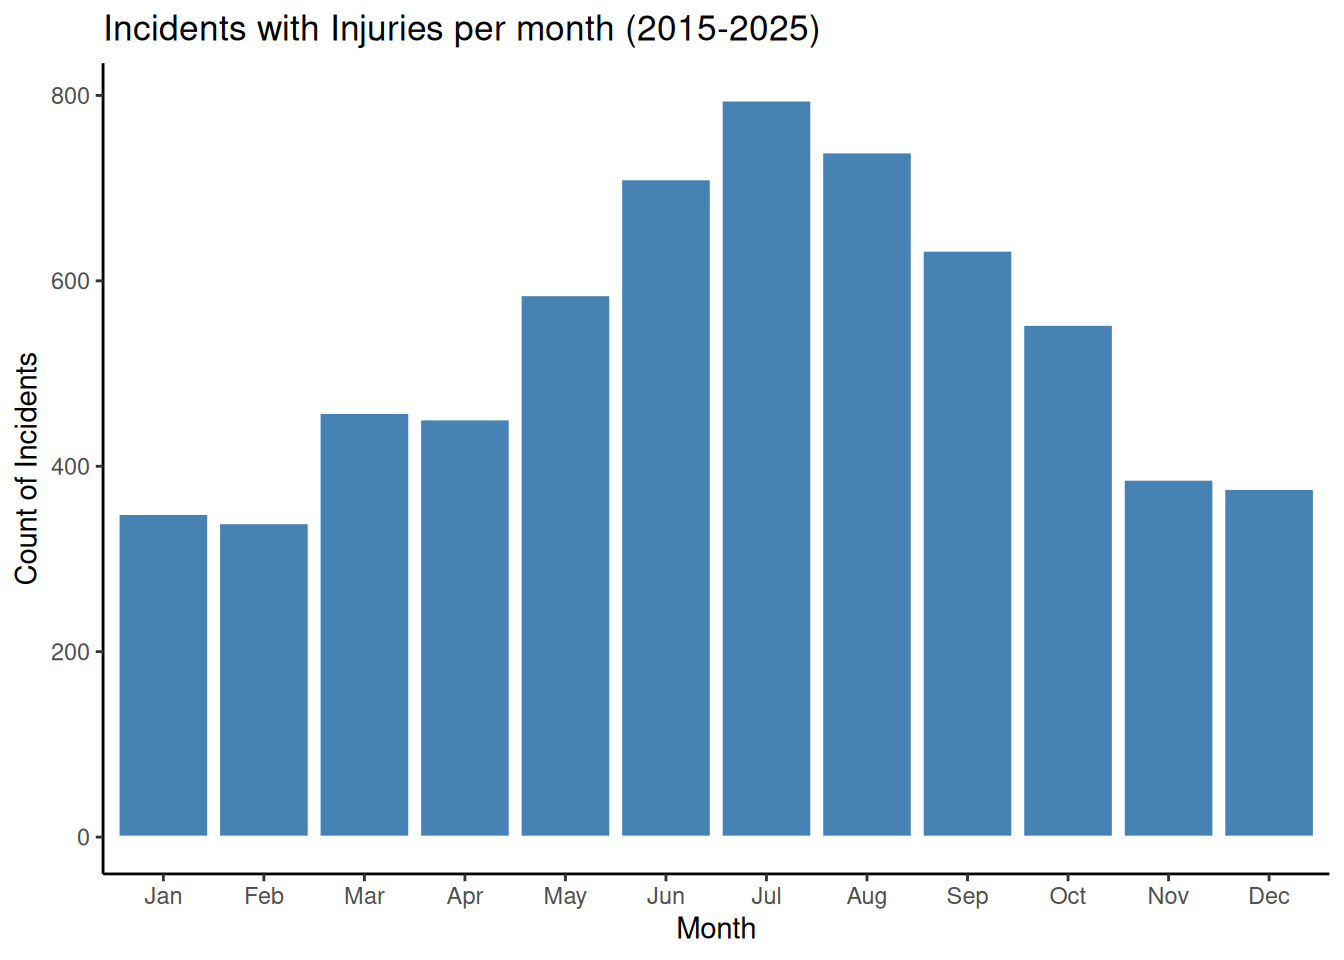

In [ ]:
# histogram by month 
ggplot(injury_df, aes(x = event_month)) +
  geom_bar(fill = "steelblue", color = "white") +
  theme_classic() +
  labs(
    title = "Incidents with Injuries per month (2015-2025)",
    x = "Month",
    y = "Count of Incidents"
  )

Figure 7: Monthly Distribution of Incidents with Injuries for 2015-2025

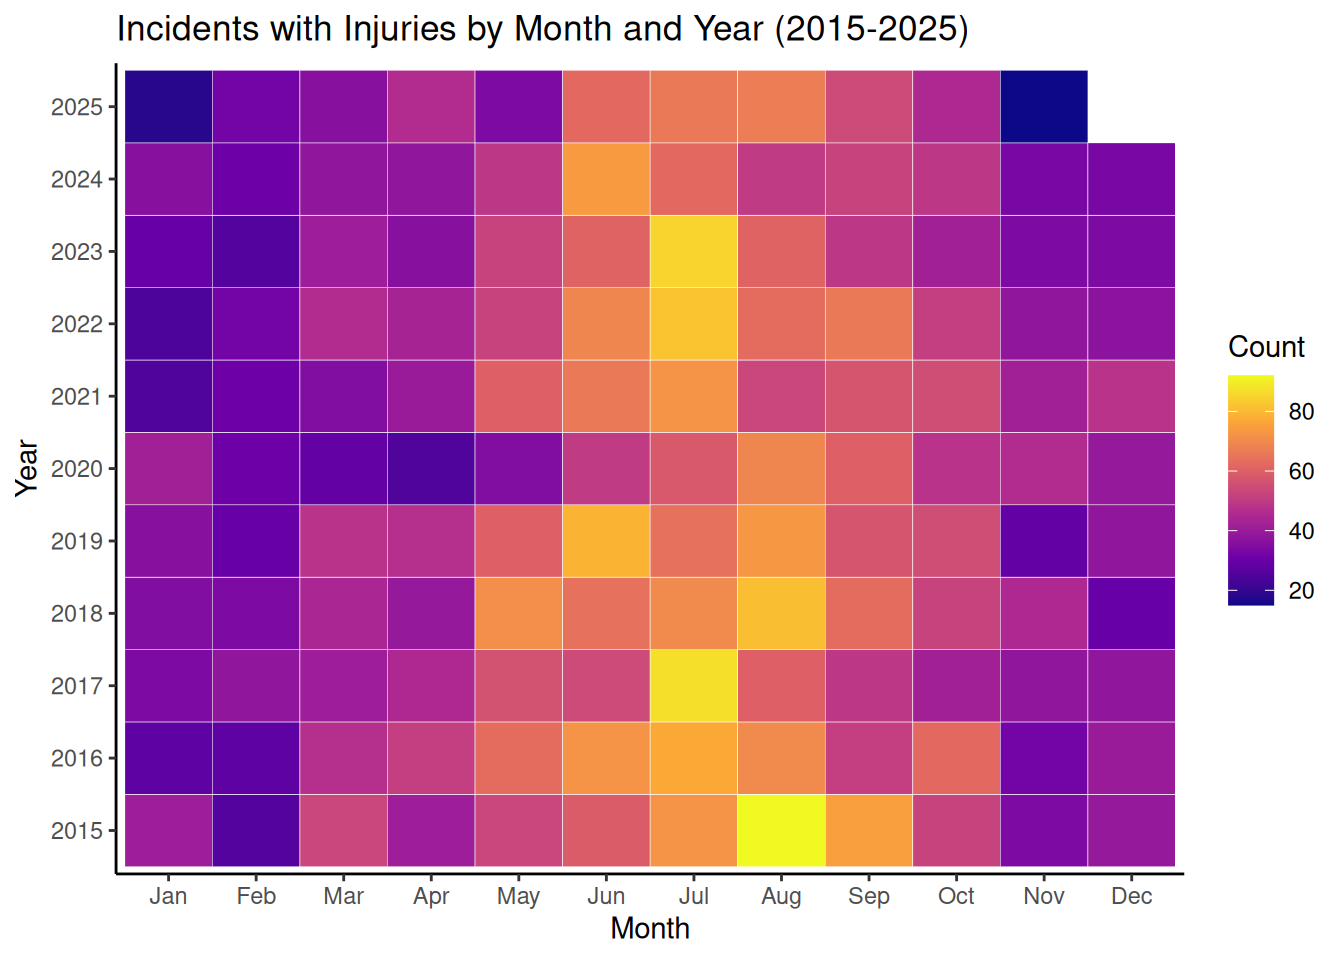

In [ ]:
# heat map by year and month 
injury_df |>
  count(event_year, event_month) |>
  ggplot(aes(x = event_month, y = factor(event_year), fill = n)) +
  geom_tile(color = "white") +
  scale_fill_viridis_c(option = "C") +
  labs(
    title = "Incidents with Injuries by Month and Year (2015-2025)",
    x = "Month",
    y = "Year",
    fill = "Count"
  ) +
  theme_classic()

Figure 8: Heatmap distribution of monthly incidents by year. July 2017 saw the most incidents reported.

#### 1.1.2.2 Incidents by Type - Incidents with Injuries

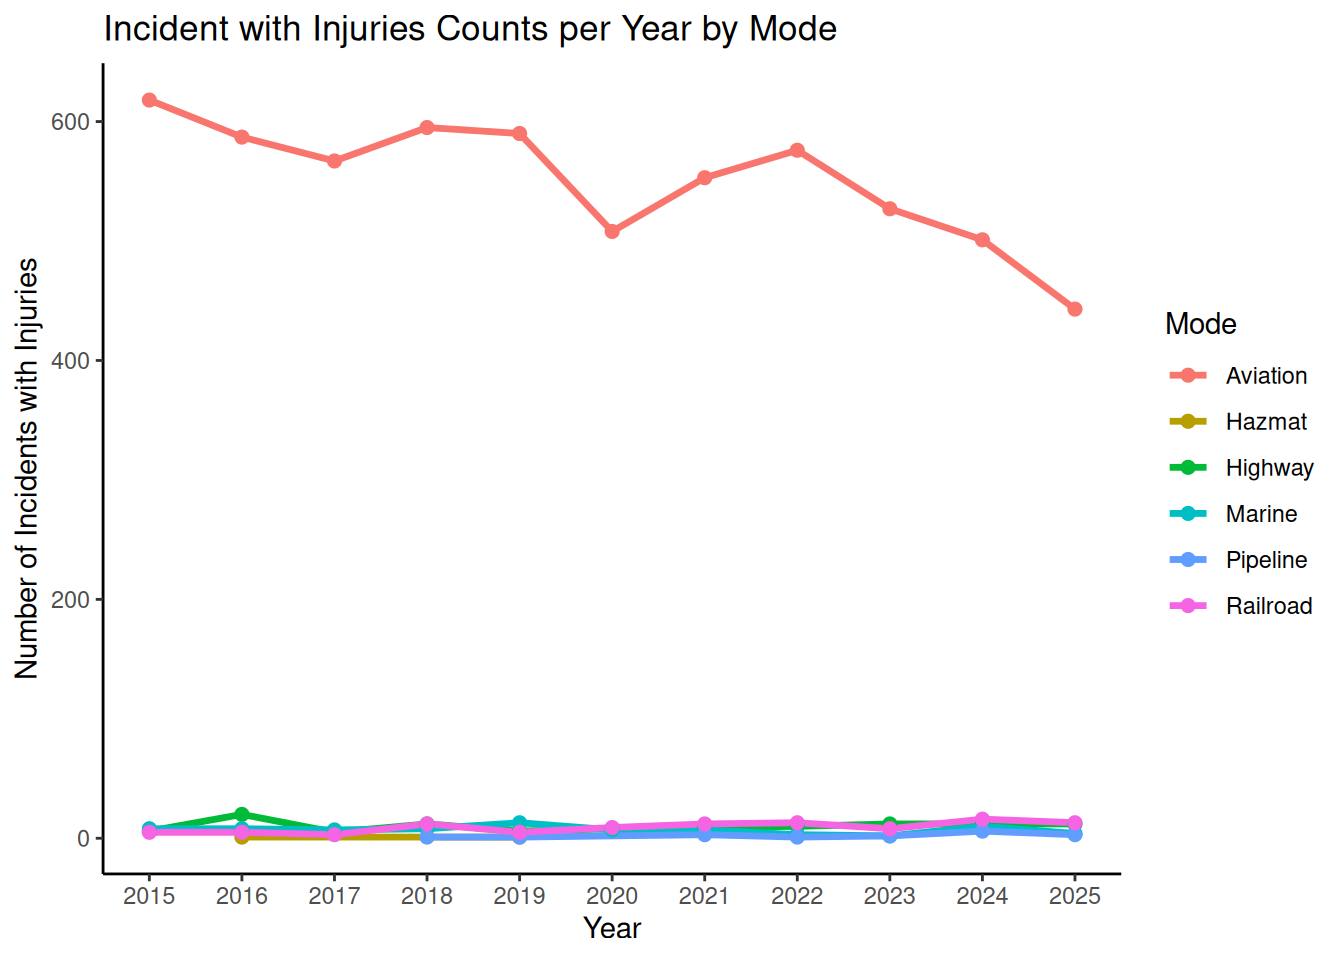

In [ ]:
# hist on year and mode
injuries_year_mode_counts <- injury_df |>
  count(event_year, cm_mode, name = "count") |>
  arrange(event_year, cm_mode)

ggplot(injuries_year_mode_counts, aes(x = event_year, y = count, color = cm_mode)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 2) +
  theme_classic() +
  labs(
    title = "Incident with Injuries Counts per Year by Mode",
    x = "Year",
    y = "Number of Incidents with Injuries",
    color = "Mode"
  ) +
  scale_x_continuous(breaks = unique(injuries_year_mode_counts$event_year))

Figure 9: Line plot of temporal trends in incident count by Mode. Aviation incidents account for the vast majority of incidents reported.

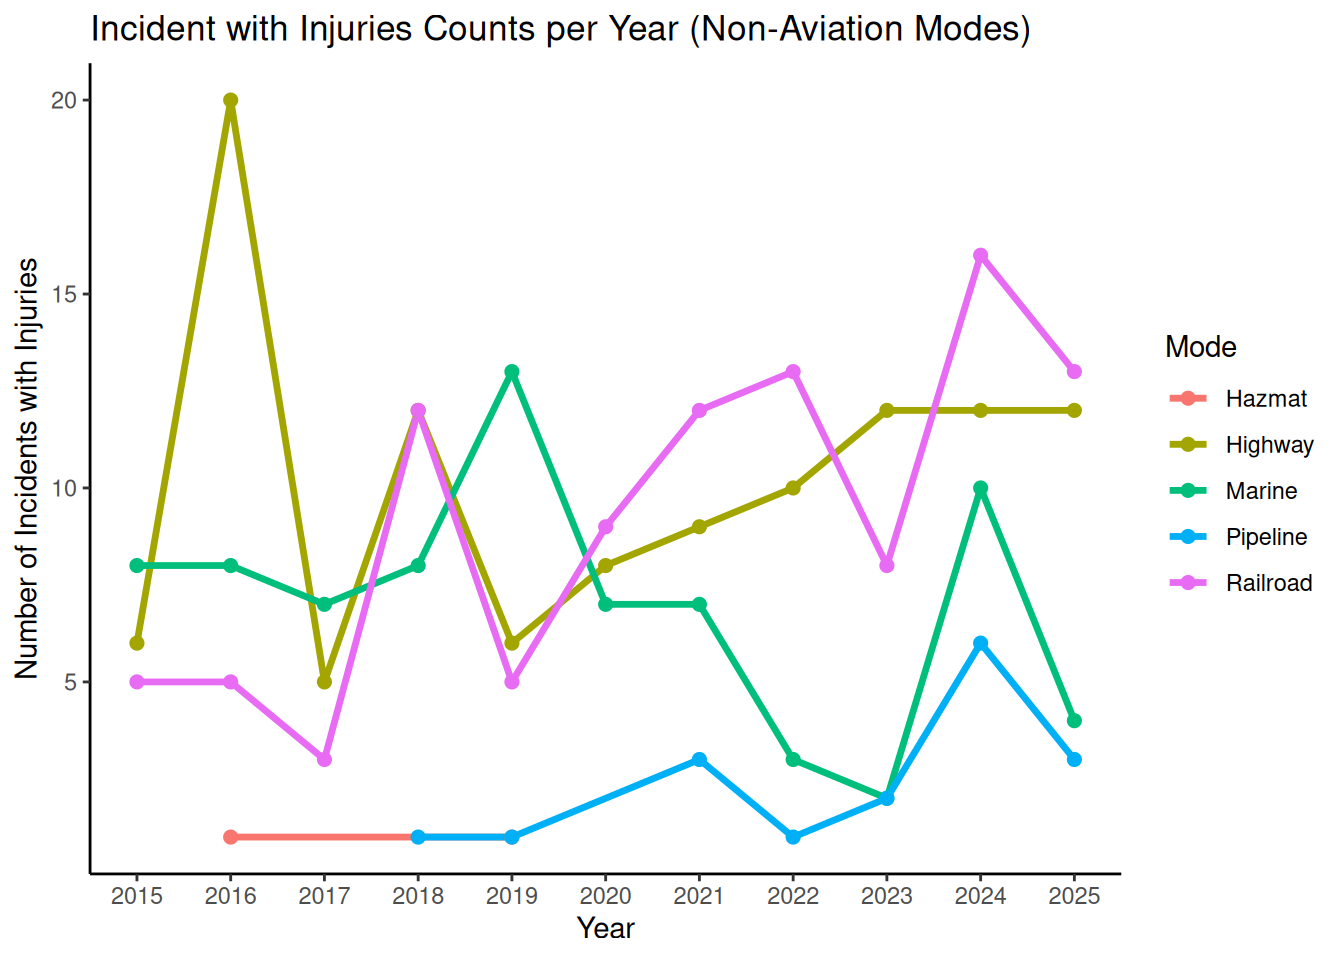

In [ ]:
# non-aviation
ggplot(
  filter(injuries_year_mode_counts, cm_mode != "Aviation"),
  aes(x = event_year, y = count, color = cm_mode)
) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 2) +
  theme_classic() +
  labs(
    title = "Incident with Injuries Counts per Year (Non-Aviation Modes)",
    x = "Year",
    y = "Number of Incidents with Injuries",
    color = "Mode"
  ) +
  scale_x_continuous(breaks = unique(injuries_year_mode_counts$event_year))

Figure 10: Line plot of temporal trends in incident count for only incidents with injuries by Mode, excluding aviation for more minute visual of other modes.

### 1.1.3 Monte Carlo Simulations for Spatial Relationships Between Incidents and Military Bases

Next, I calculated the observed mean distance of all incidents to the nearest military base. After recording this value, I ran 100-500 Monte Carlo simulations (dependent on region – less simulations because of the time required to run the analysis) and compared the distribution of Monte Carlo simulation results to the observed mean. I performed this test for the nine geographical regions of the U.S. individyally as defined by the U.S. Census Bureau to be able to run shorter pieces of code. I initially ran the analysis for the West Pacific region (WA, OR, CA) and the West South Central region (TX, OK, AR, LA) and after getting completely opposite results with a $p$-value of 1 for the West Pacific and 0 for the West South Central I generalized the code to be able to run for all of the regions to compare. For publication purposes in the Quarto Manuscript, I ran on the slightly smaller injury-only dataset. Separately, I ran the full dataset and included those visuals for comparison.

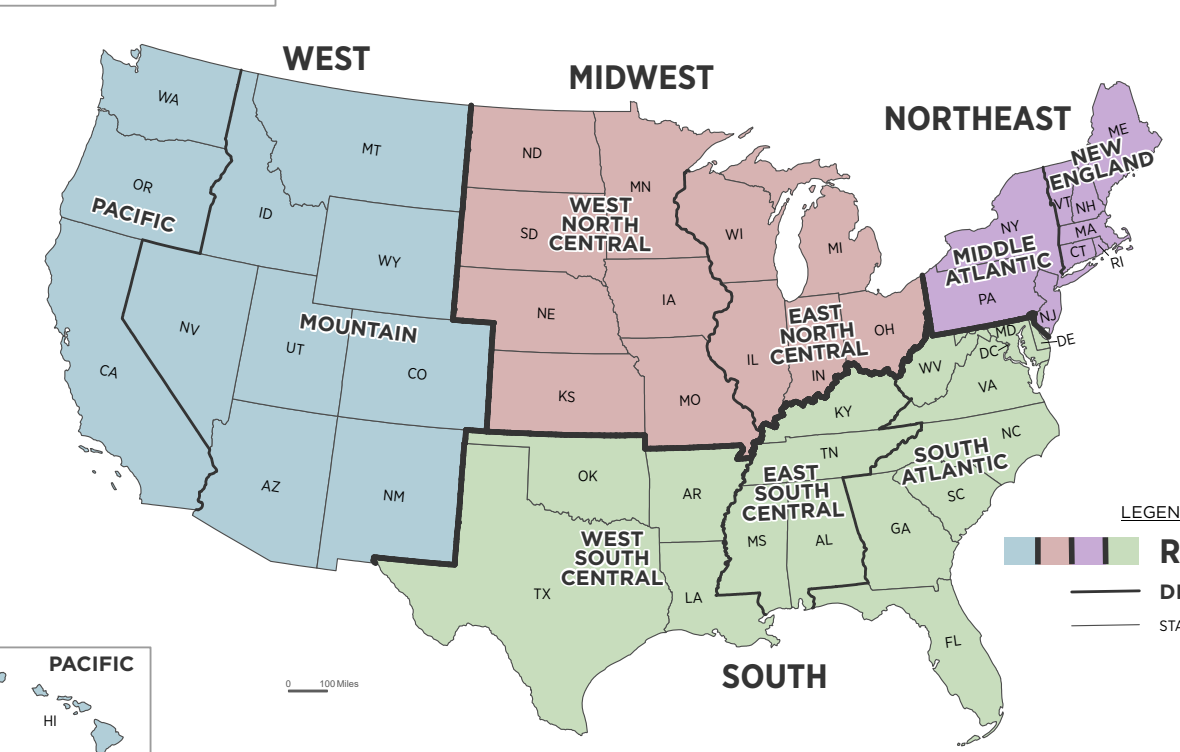.

In [ ]:
region_states <- list(
  WCS = c("Texas", "Oklahoma", "Arkansas", "Louisiana"),
  WP = c("California", "Oregon", "Washington"),
  WM = c("Montana", "Idaho", "Wyoming", "Nevada", "Utah", "Colorado", "Arizona", "New Mexico"),
  WNC = c("North Dakota", "South Dakota", "Minnesota", "Nebraska", "Kansas", "Iowa", "Kansas", "Missouri"),
  ENC = c("Wisconsin", "Michigan", "Illinois", "Indiana", "Ohio"),
  ESC = c("Kentucky", "Tennessee", "Missippi", "Alabama"),
  SA = c("Florida", "Georgia", "South Carolina", "North Carolina", "Virginia", "West Virginia", "Washington D.C.", "Maryland", "Delaware"),
  MA = c("New York", "Pennsylvania", "New Jersey"),
  NE = c("Connecticut", "Massachussetts", "Vermont", "New Hampshire", "Rhode Island", "Maine")
)

message("Regions as Defined By U.S. Census Bureau:")

Regions as Defined By U.S. Census Bureau:

$WCS
[1] "Texas"     "Oklahoma"  "Arkansas"  "Louisiana"

$WP
[1] "California" "Oregon"     "Washington"

$WM
[1] "Montana"    "Idaho"      "Wyoming"    "Nevada"     "Utah"      
[6] "Colorado"   "Arizona"    "New Mexico"

$WNC
[1] "North Dakota" "South Dakota" "Minnesota"    "Nebraska"     "Kansas"      
[6] "Iowa"         "Kansas"       "Missouri"    

$ENC
[1] "Wisconsin" "Michigan"  "Illinois"  "Indiana"   "Ohio"     

$ESC
[1] "Kentucky"  "Tennessee" "Missippi"  "Alabama"  

$SA
[1] "Florida"         "Georgia"         "South Carolina"  "North Carolina" 
[5] "Virginia"        "West Virginia"   "Washington D.C." "Maryland"       
[9] "Delaware"       

$MA
[1] "New York"     "Pennsylvania" "New Jersey"  

$NE
[1] "Connecticut"    "Massachussetts" "Vermont"        "New Hampshire" 
[5] "Rhode Island"   "Maine"         

In [ ]:
injury_cases_3857 <- cases_3857 |>
  filter(cm_highestInjury != "None")

for (region in region_keys){
  message("Running region: ", region)

  results_list[[region]] <- run_region_analysis(
  region_states = get_region_states(region),
  region_label = region,
  cases_3857 = injury_cases_3857,
  bases_centroids = bases_centroids,
  us_states = us_states,
  N = 100,
  output_dir = "images/injury/"
)
}

Running region: WCS

=== Running analysis for region: WCS ===

States: TexasOklahomaArkansasLouisiana

all geometries
all geometries

Cases in region: 906

Bases in region: 66

Observed mean distance (miles): 353.89


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 0

Plot saved to: images/injury/WCS_distance_distribution.png

Running region: WP

=== Running analysis for region: WP ===

States: CaliforniaOregonWashington

all geometries
all geometries

Cases in region: 865

Bases in region: 102

Observed mean distance (miles): 582.16


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 1

Plot saved to: images/injury/WP_distance_distribution.png

Running region: WM

=== Running analysis for region: WM ===

States: MontanaIdahoWyomingNevadaUtahColoradoArizonaNew Mexico

all geometries
all geometries

Cases in region: 972

Bases in region: 84

Observed mean distance (miles): 621.17


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 0

Plot saved to: images/injury/WM_distance_distribution.png

Running region: WNC

=== Running analysis for region: WNC ===

States: North DakotaSouth DakotaMinnesotaNebraskaKansasIowaKansasMissouri

all geometries
all geometries

Cases in region: 502

Bases in region: 65

Observed mean distance (miles): 481.89


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 0

Plot saved to: images/injury/WNC_distance_distribution.png

Running region: ENC

=== Running analysis for region: ENC ===

States: WisconsinMichiganIllinoisIndianaOhio

all geometries
all geometries

Cases in region: 611

Bases in region: 60

Observed mean distance (miles): 327.91


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 0

Plot saved to: images/injury/ENC_distance_distribution.png

Running region: ESC

=== Running analysis for region: ESC ===

States: KentuckyTennesseeMissippiAlabama

all geometries
all geometries

Cases in region: 280

Bases in region: 51

Observed mean distance (miles): 250.06


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 0

Plot saved to: images/injury/ESC_distance_distribution.png

Running region: SA

=== Running analysis for region: SA ===

States: FloridaGeorgiaSouth CarolinaNorth CarolinaVirginiaWest VirginiaWashington D.C.MarylandDelaware

all geometries
all geometries

Cases in region: 1129

Bases in region: 171

Observed mean distance (miles): 454.24


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 1

Plot saved to: images/injury/SA_distance_distribution.png

Running region: MA

=== Running analysis for region: MA ===

States: New YorkPennsylvaniaNew Jersey

all geometries
all geometries

Cases in region: 351

Bases in region: 50

Observed mean distance (miles): 208.03


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 0

Plot saved to: images/injury/MA_distance_distribution.png

Running region: NE

=== Running analysis for region: NE ===

States: ConnecticutMassachussettsVermontNew HampshireRhode IslandMaine

all geometries
all geometries

Cases in region: 119

Bases in region: 33

Observed mean distance (miles): 192.15


  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                                                            
  |===                                                                   |   4%
  |                                                                            
  |====                                                                  |   5%
  |                                    

P-value: 0

Plot saved to: images/injury/NE_distance_distribution.png

## 1.2 Findings

### 1.2.1 Initial Findings - West Pacific and West South Central Regions

I initially visualized and ran the proximity analysis for Washington, Oregon, and California only. This simulation testing resulted in a $p$-value of 1 based on 100 Monte Carlo simulations, indicating that **transportation incidents are *far less likely* to occur within close proximity to U.S. military bases.**.

<figure>
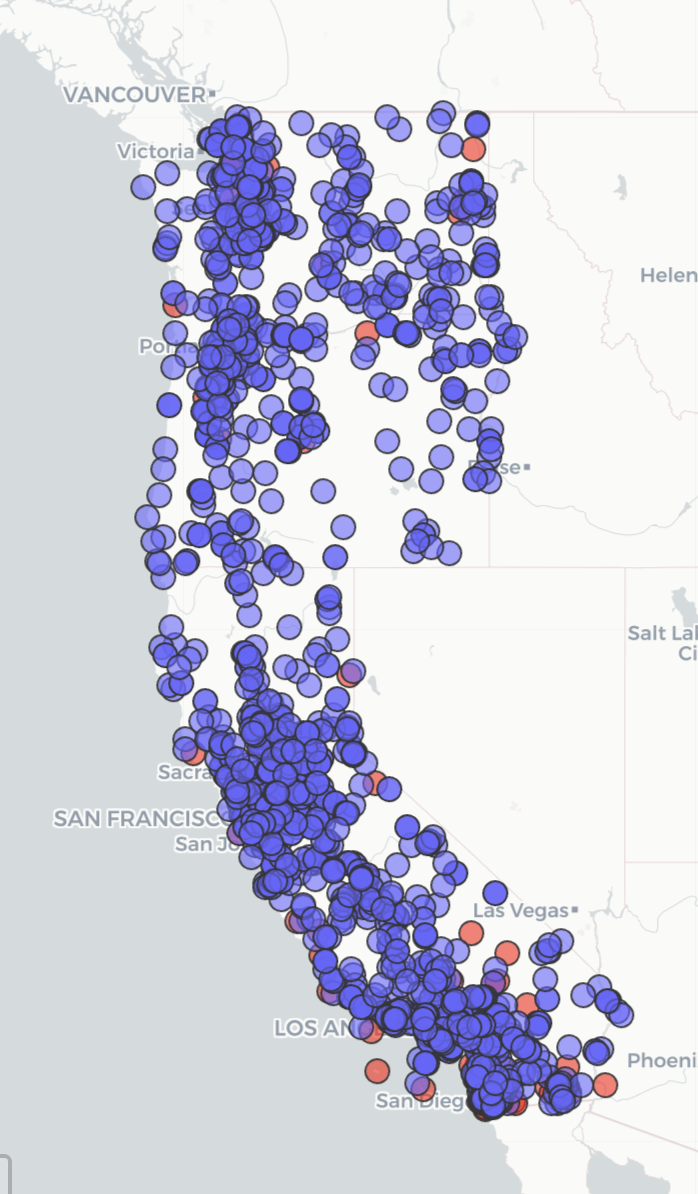
<figcaption aria-hidden="true">Figure 12: West Pacific Region Incident Map (Incidents in Blue, Military Bases in Red). Screenshot of mapview generation for rendering ability in Quarto Manuscript</figcaption>
</figure>

<figure>
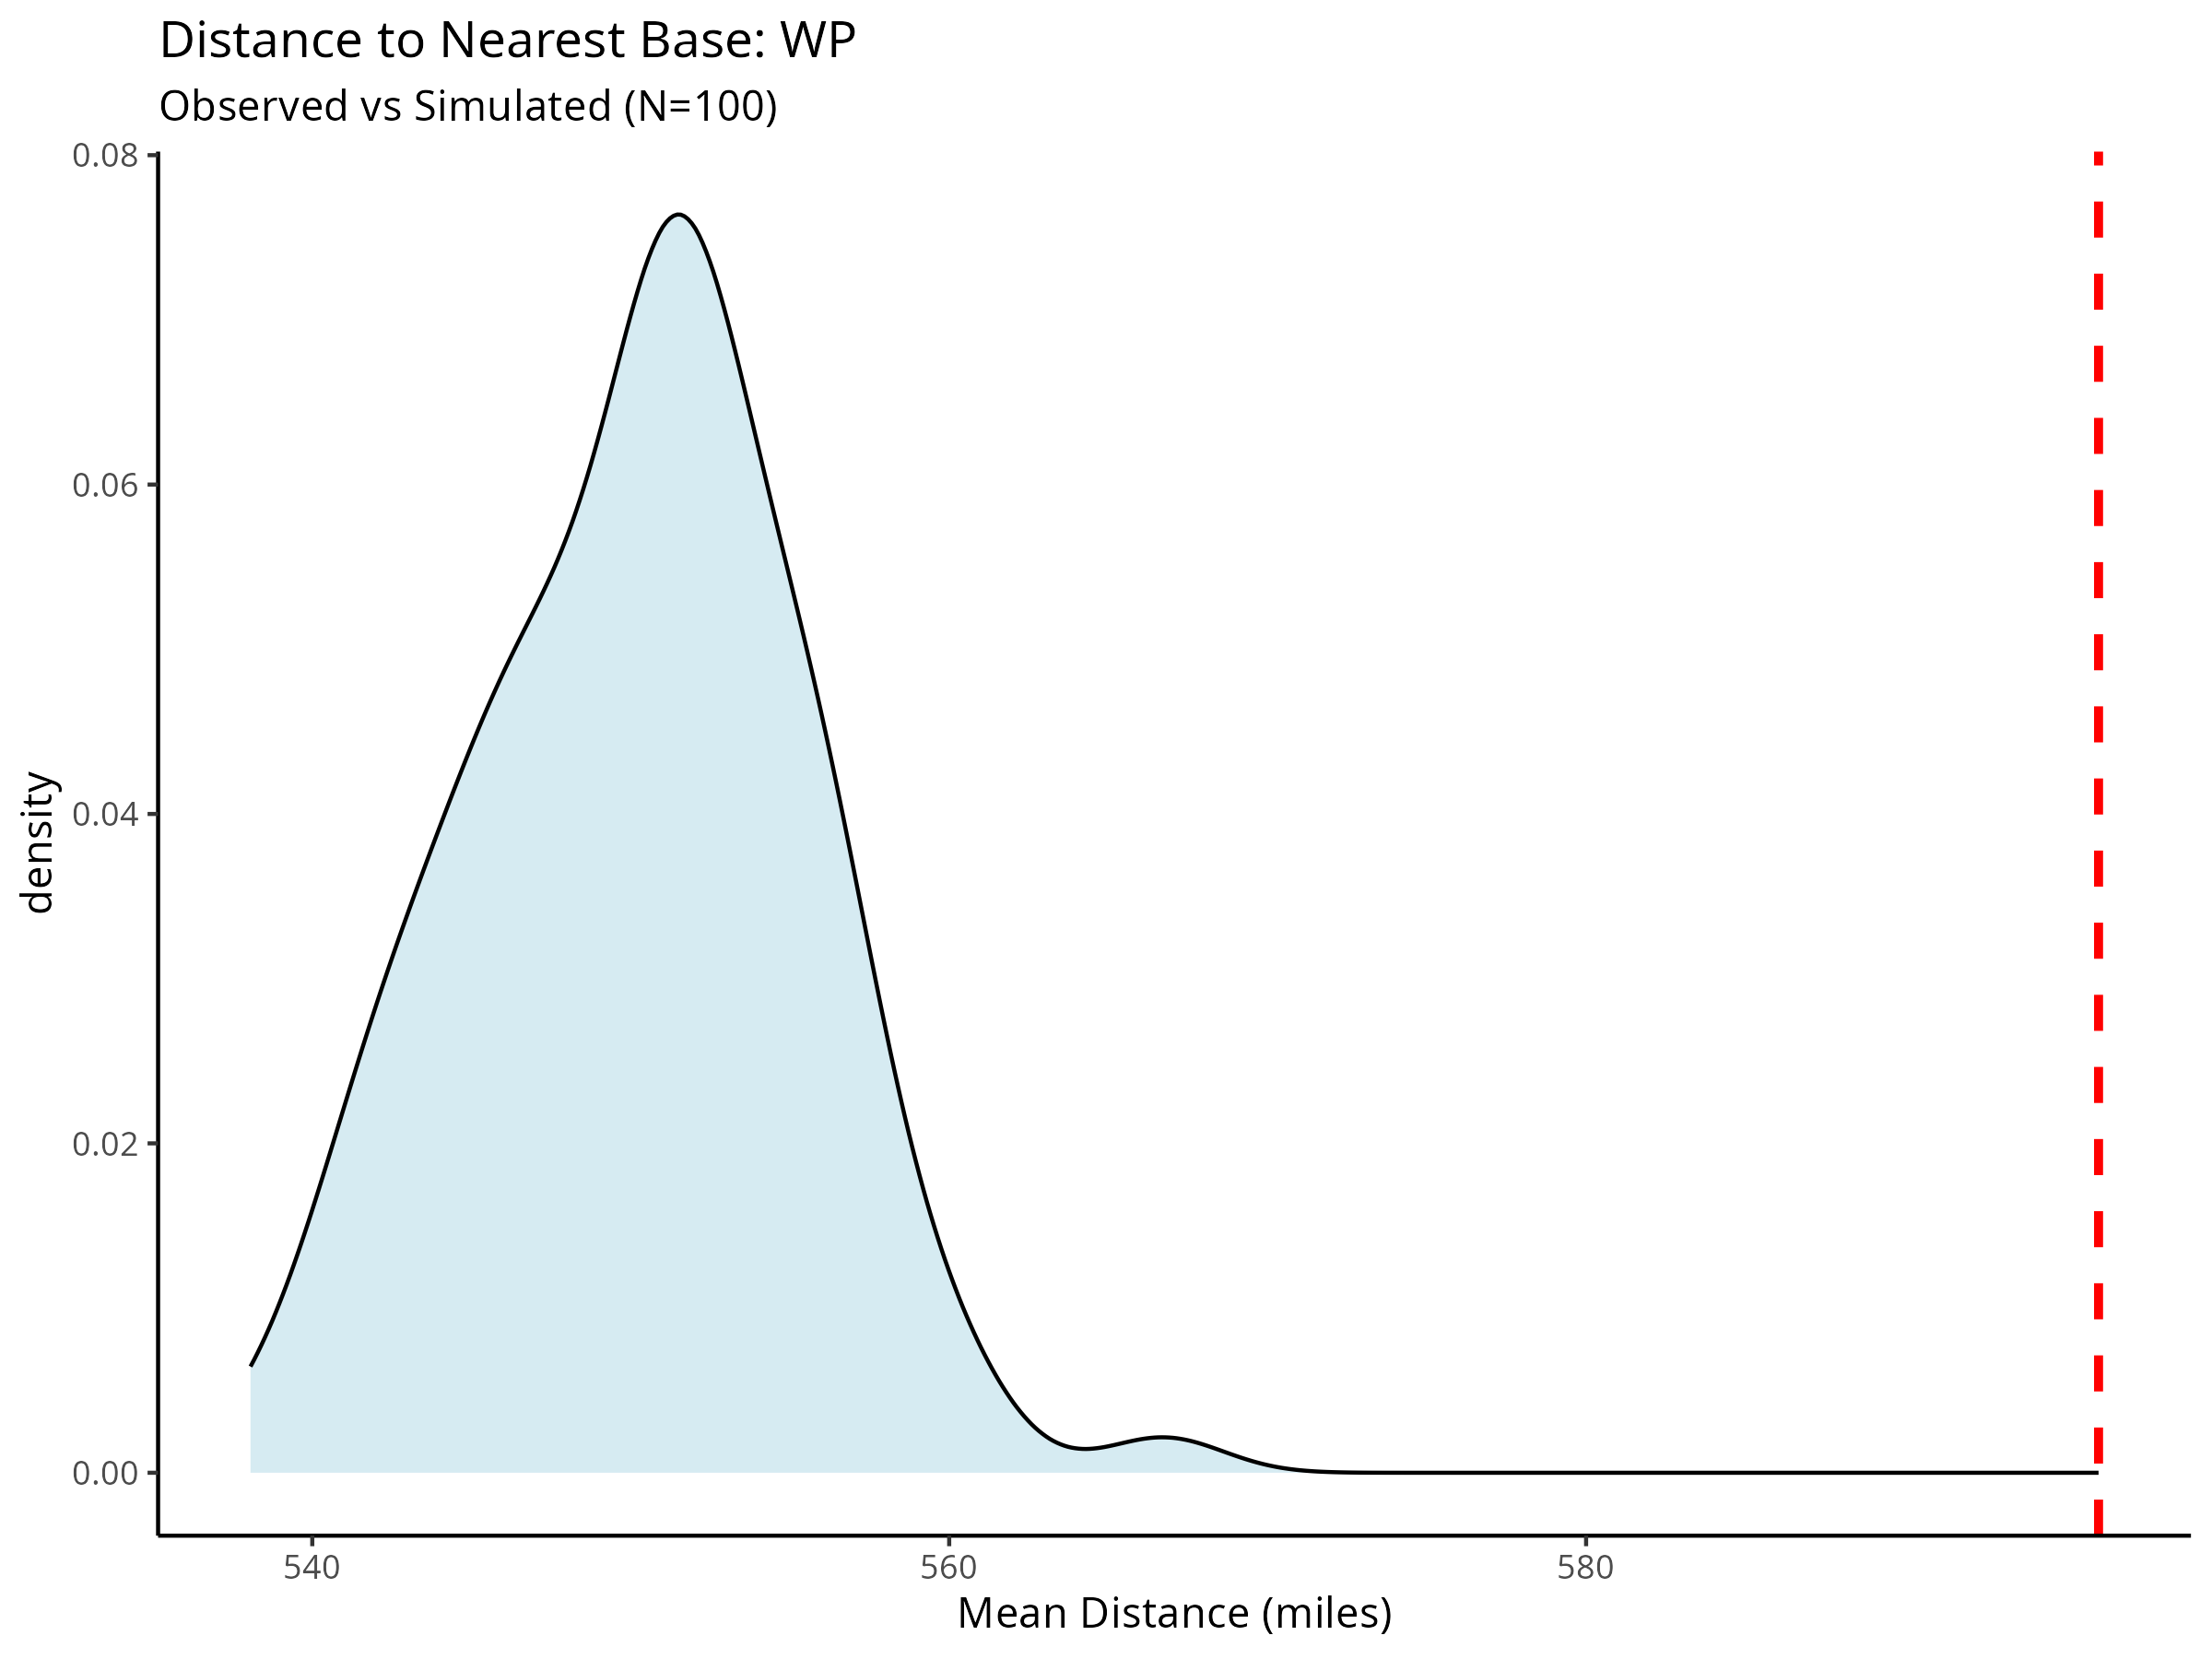
<figcaption aria-hidden="true">Figure 13: Monte Carlo Simulation Results - Distance to Nearest Base, West Pacific Region (All Incidents)</figcaption>
</figure>

<figure>
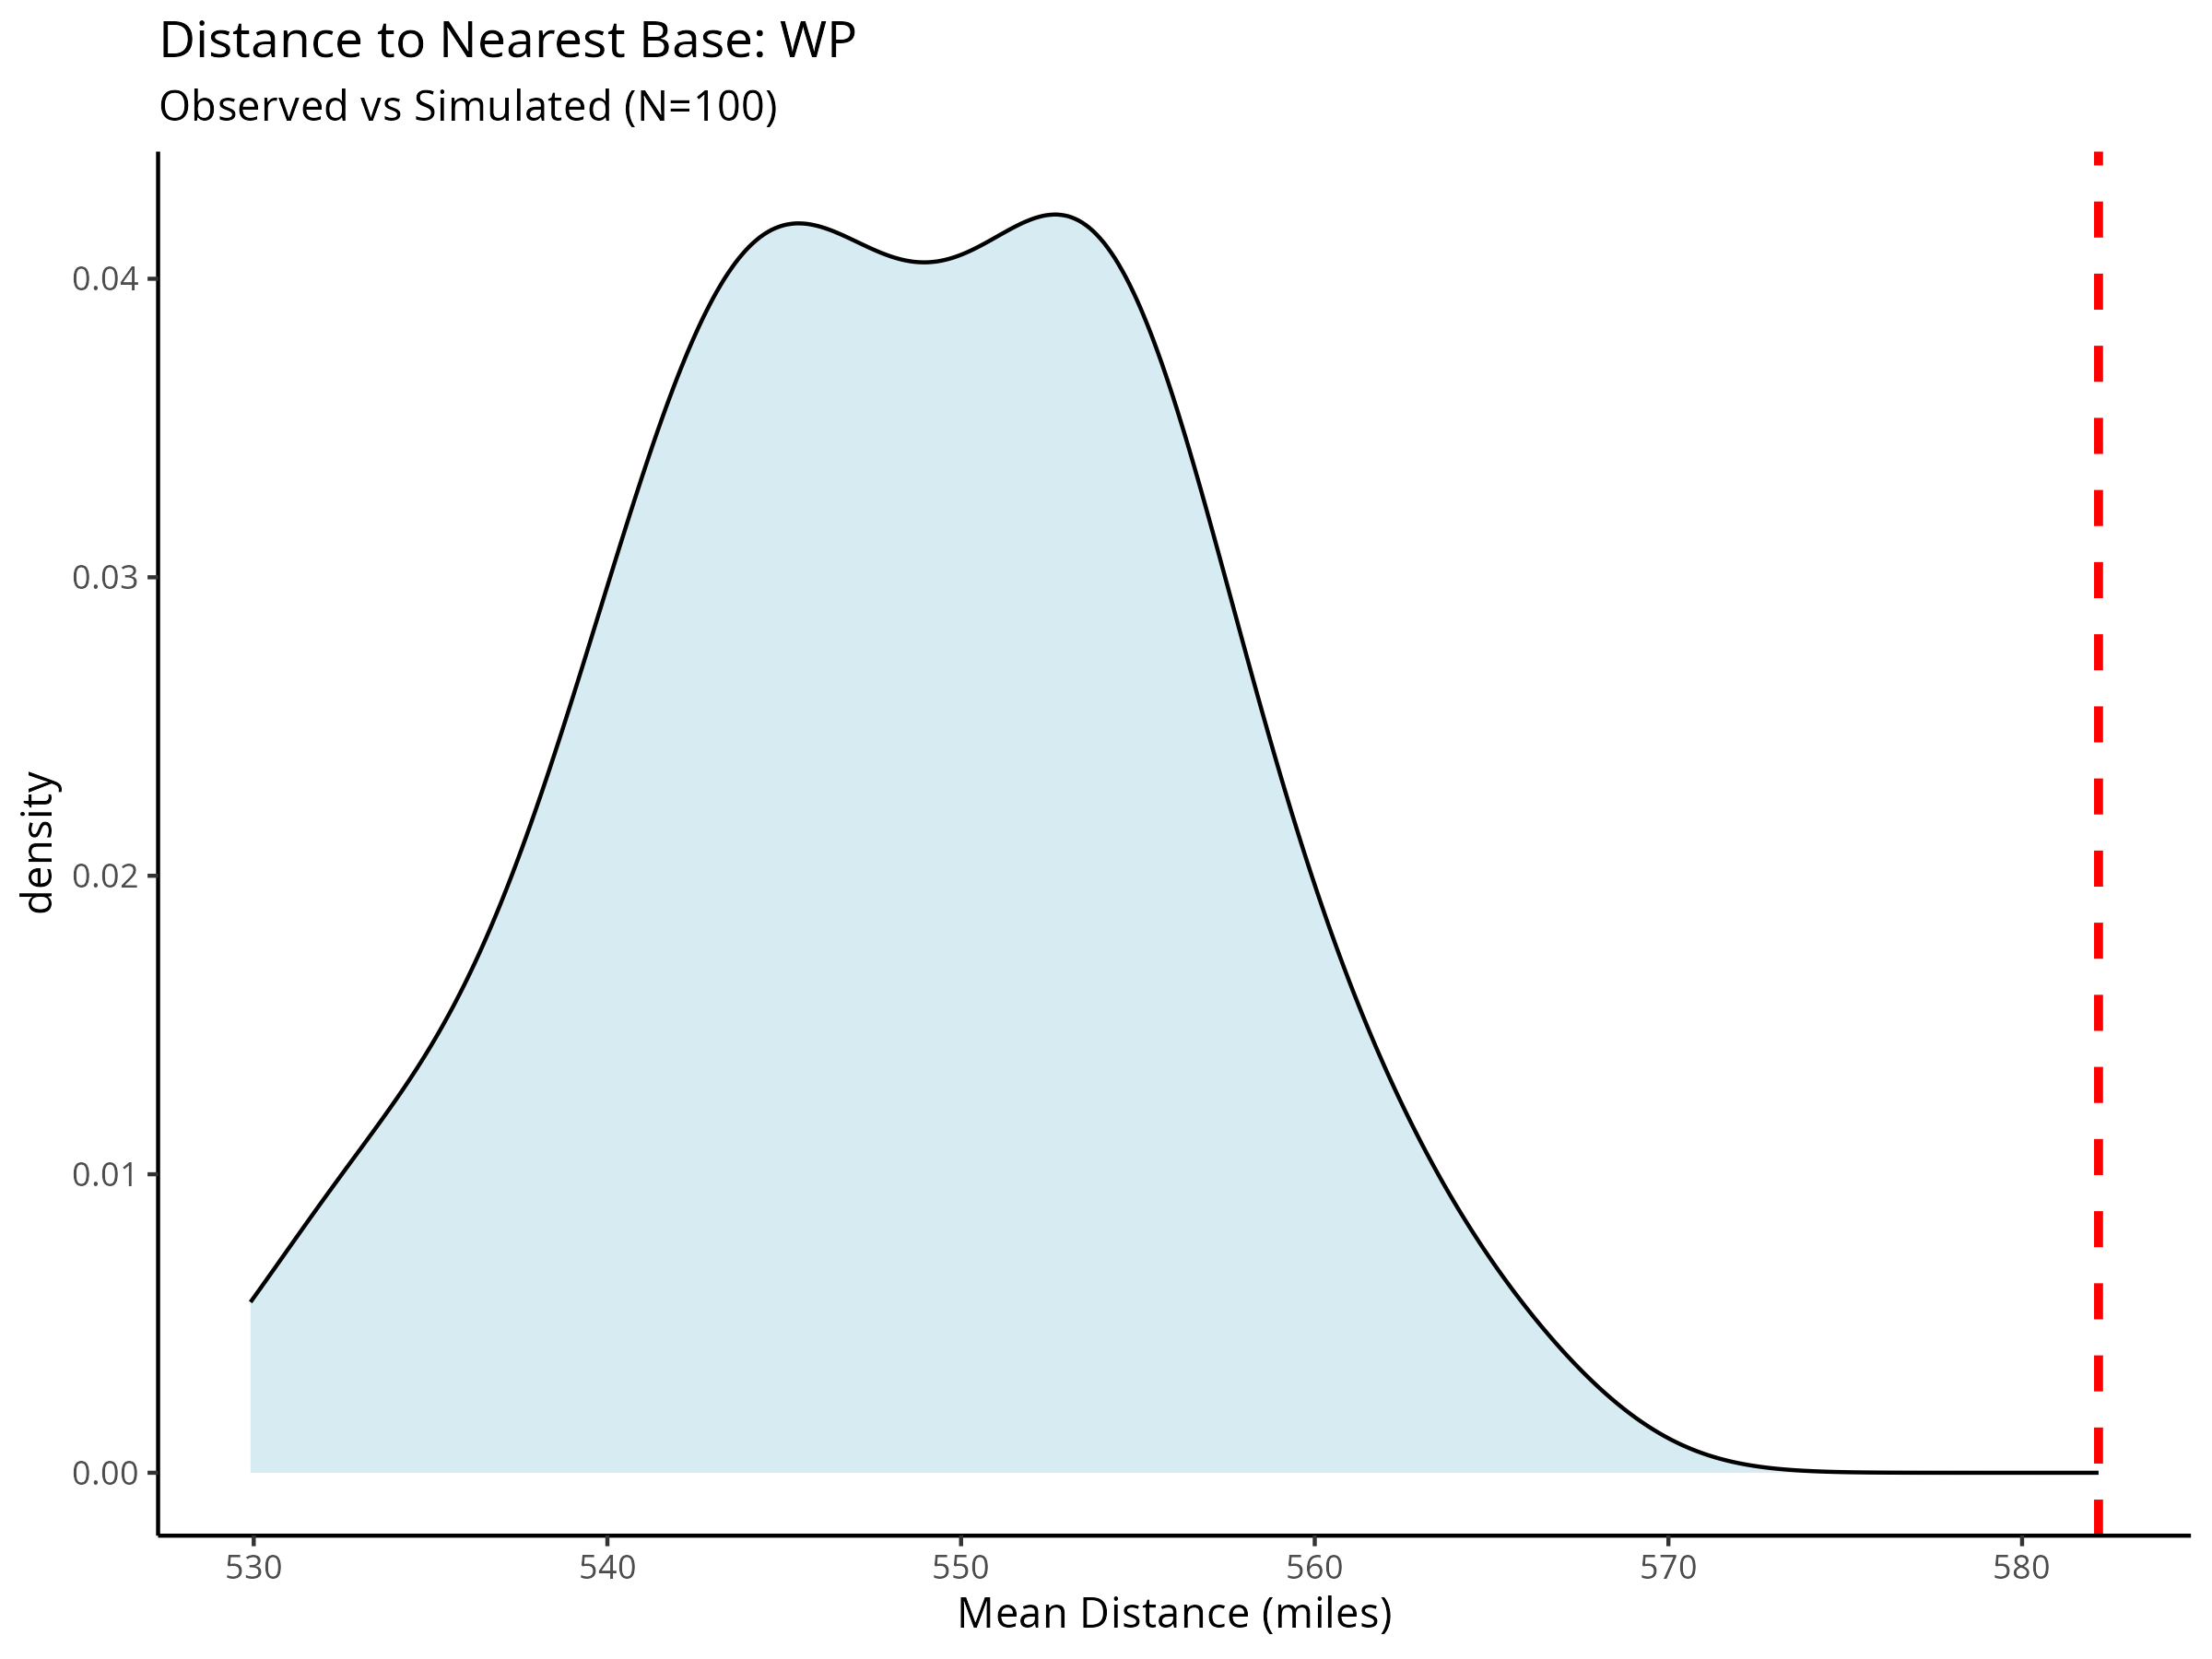
<figcaption aria-hidden="true">Figure 14: Monte Carlo Simulation Results - Distance to Nearest Base, West Pacific Region (Incidents with Injuries)</figcaption>
</figure>

However, the same process ran for the West South Central Region including Texas, Oklahoma, Arkansas, and Louisiana yielded the opposite result as shown in Figure X. The results included a $p$-value of 0 based on 100 Monte Carlo simulations, indicating that **transportation incidents are *much more likely* to occur within close proximity to U.S. military bases.**

<figure>
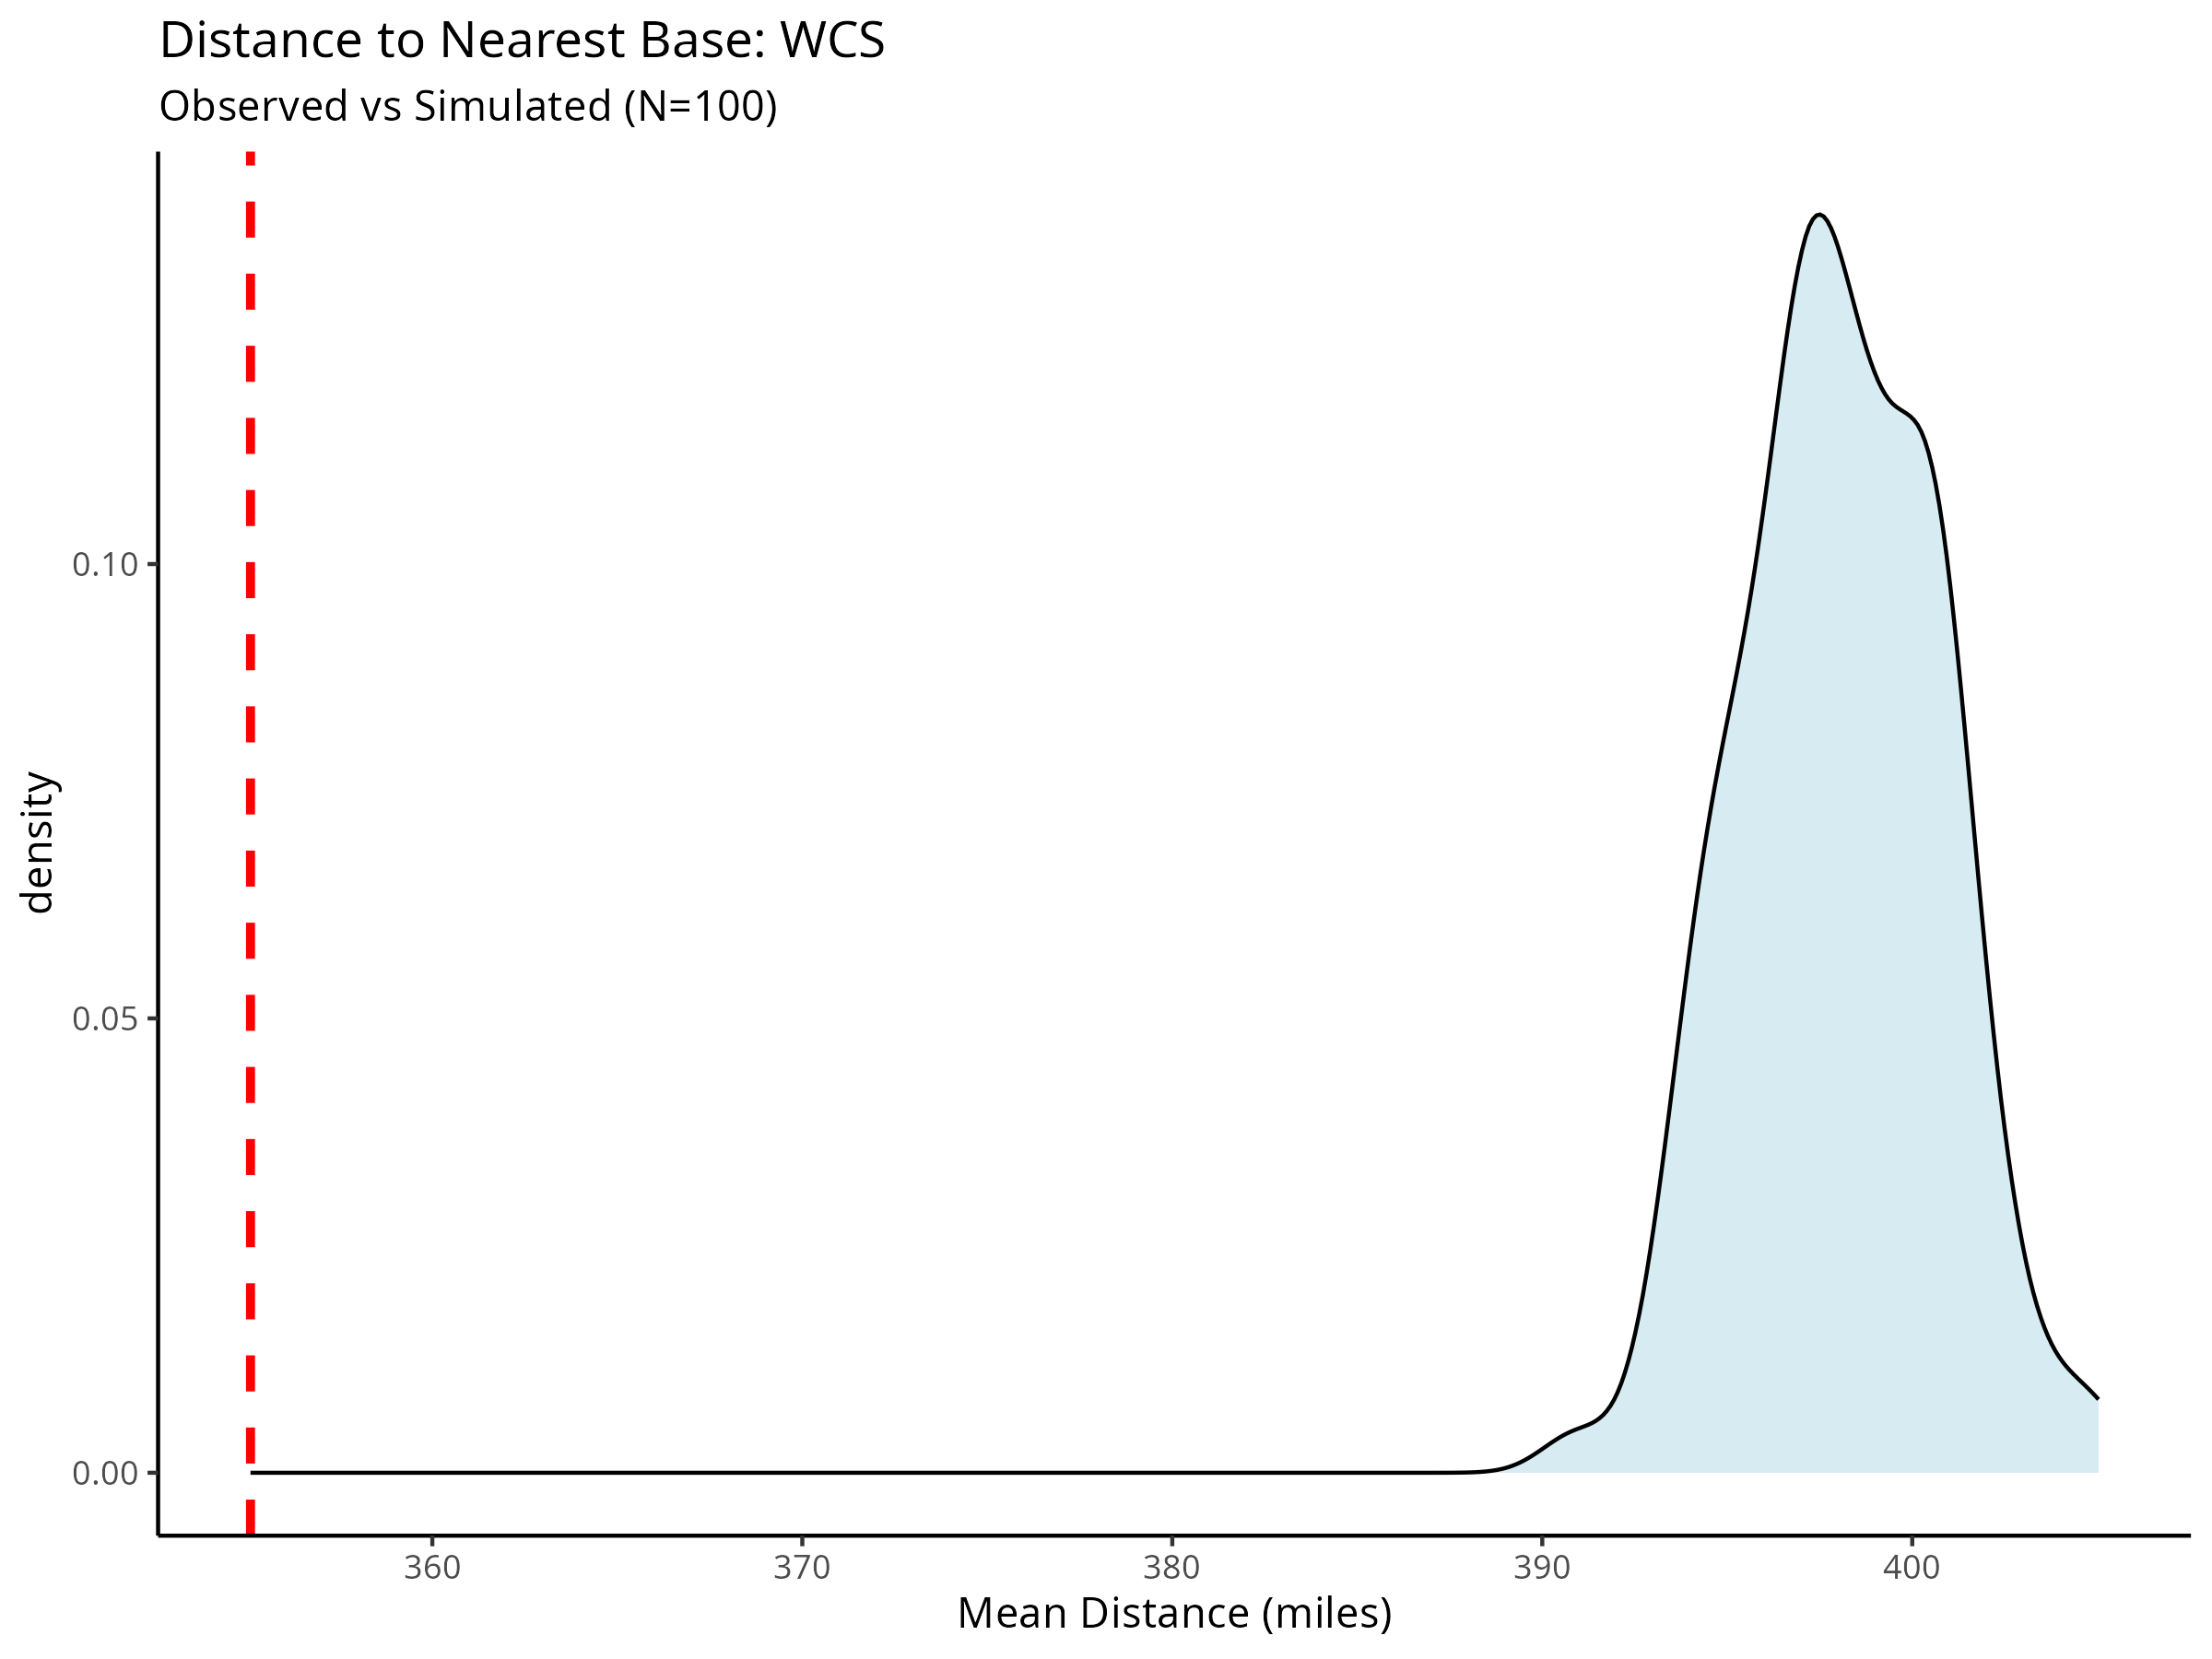
<figcaption aria-hidden="true">Figure 15: Monte Carlo Simulation Results - Distance to Nearest Base, West South Central Region (All Incidents)</figcaption>
</figure>

<figure>
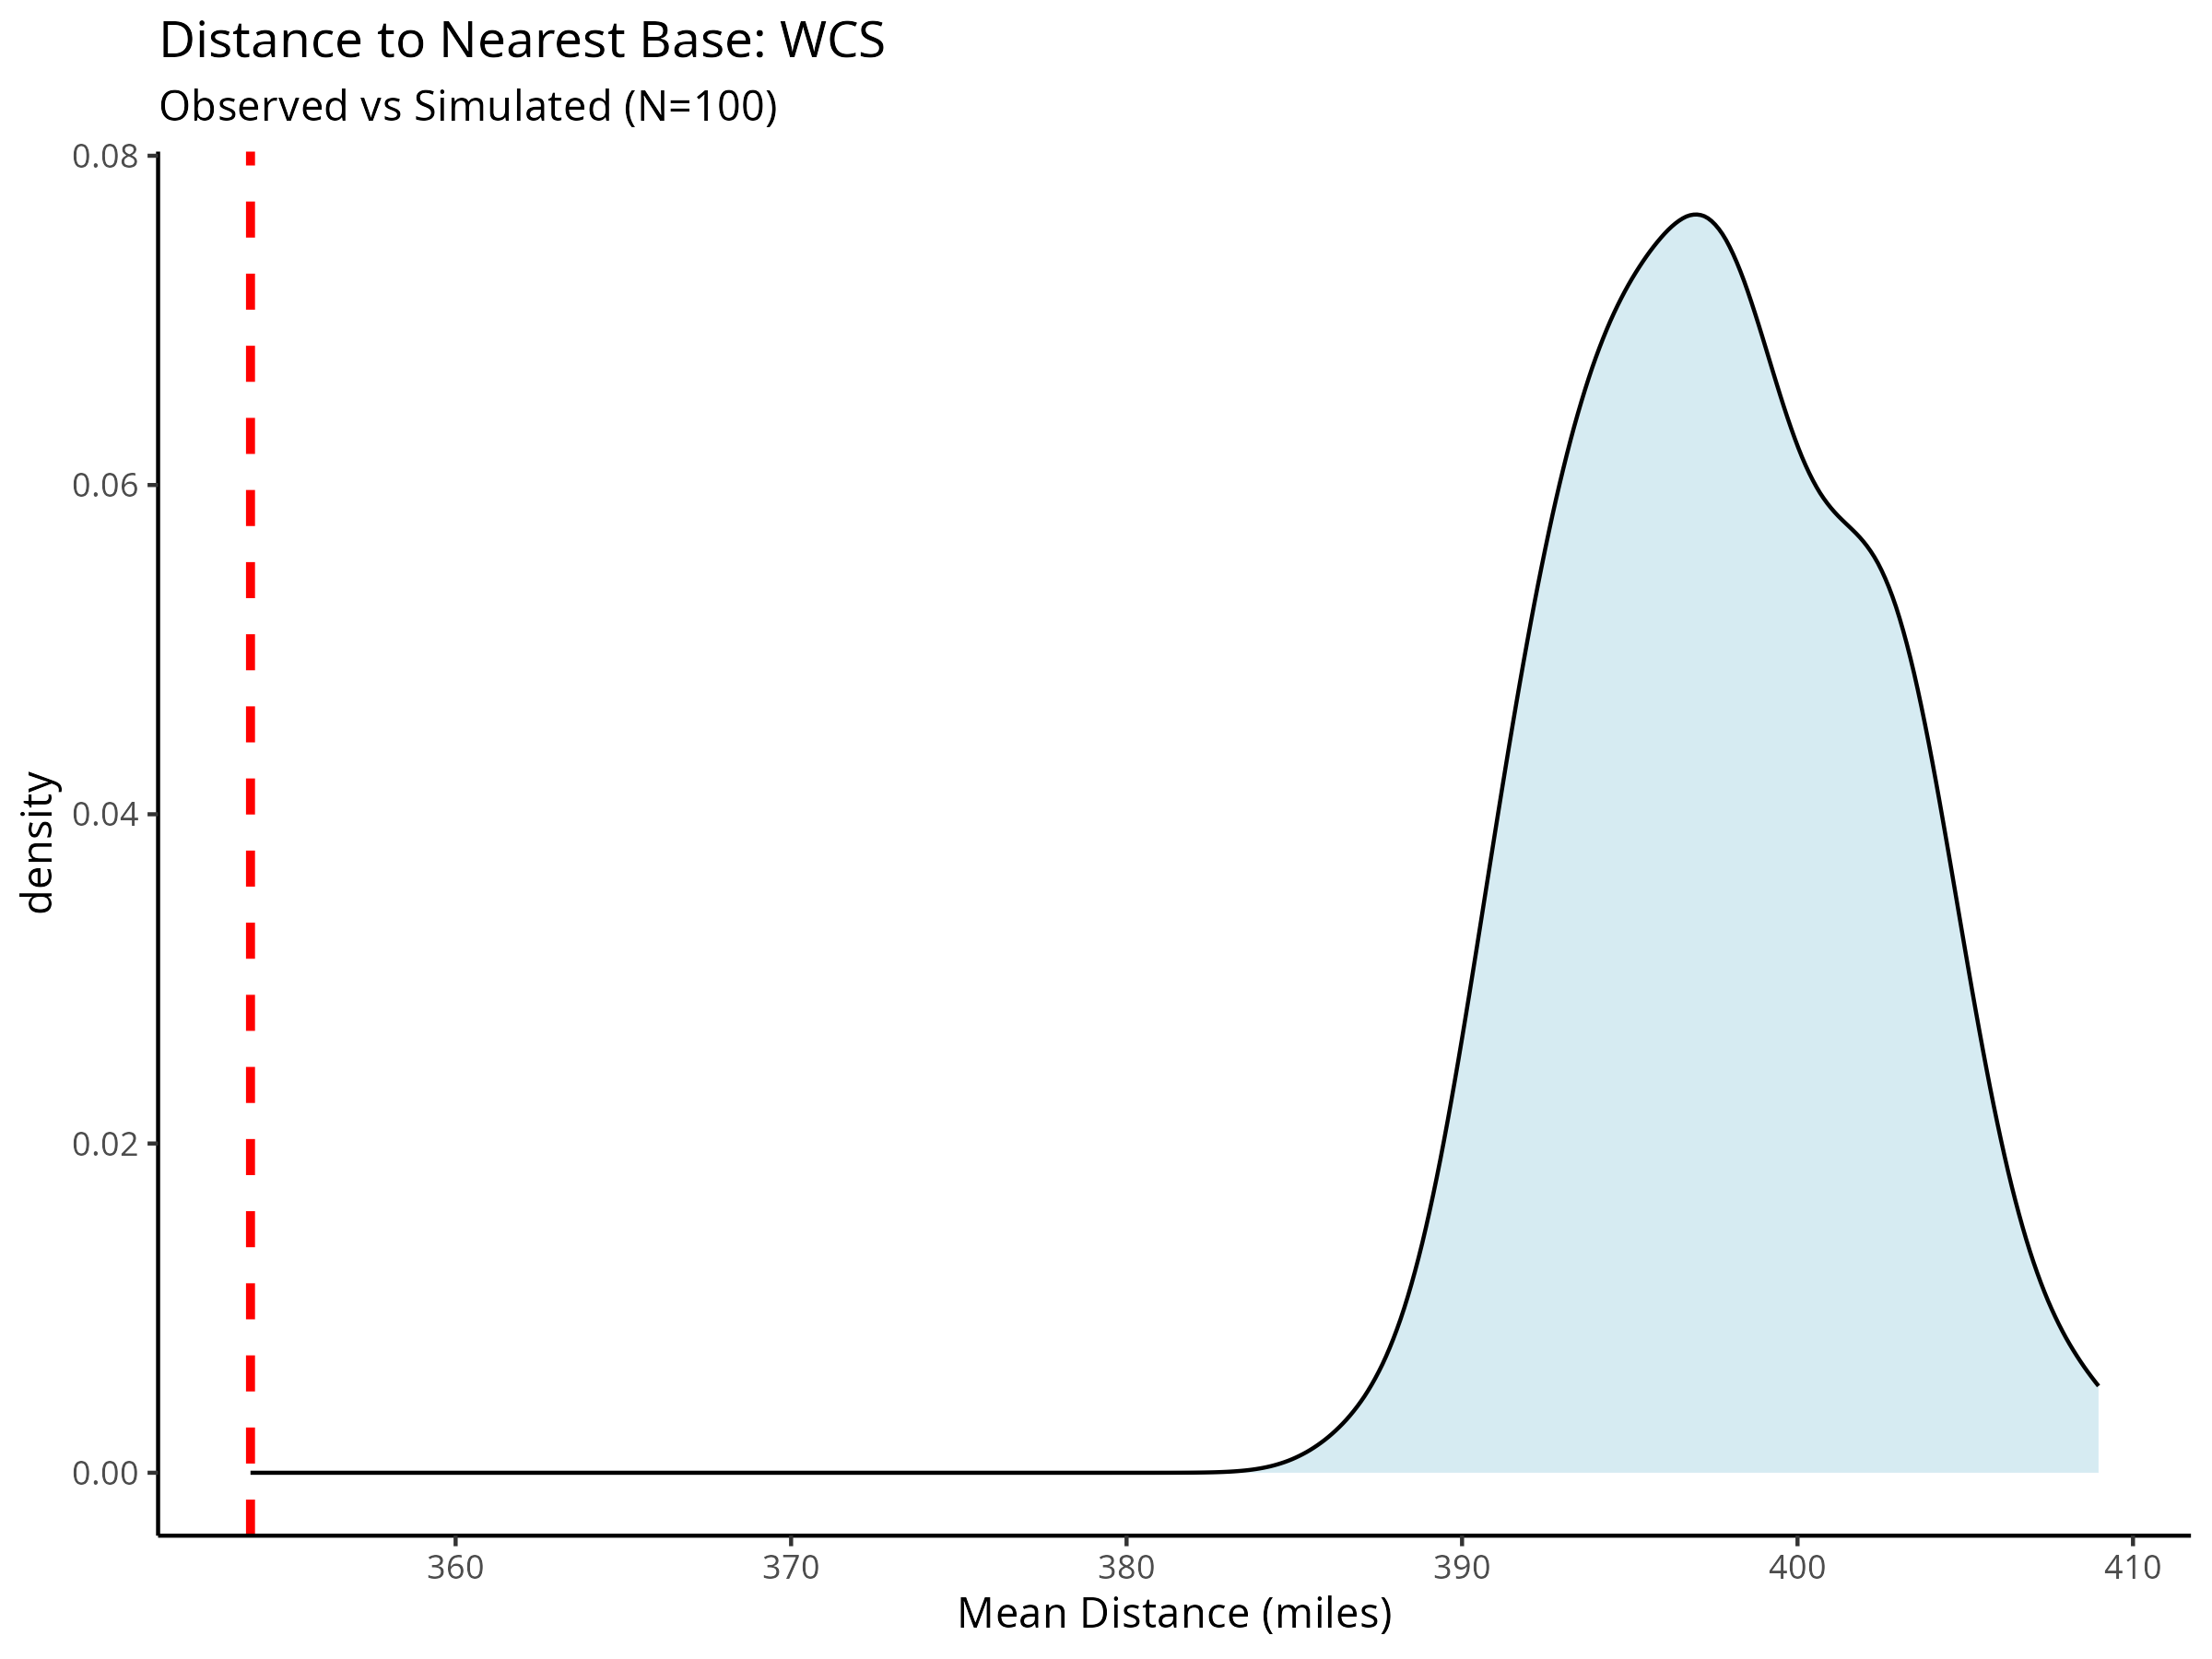
<figcaption aria-hidden="true">Figure 16: Monte Carlo Simulation Results - Distance to Nearest Base, West South Central Region (Incidents with Injuries)</figcaption>
</figure>

### 1.2.2 National Findings by Region

After running the same analysis for all of the census regions, the simulations yielded the following results:

$p$-value = 1: West Pacific, South Atlantic

$p$-value ~ 0: West South Central, West North Central, West Mountain, Middle Atlantic, New England, East South Central

For regions that were majority coastal states, the $p$-value was 1 and for majority in-land regions the $p$-value was 0. This raises questions as to the reporting requirements for aviation incidents, especially as related to the water incidents. To attempt to account for missed incidents due to the bounding box, I expanded the initial bounding box for the regional limitations, but got the same results.

*Note: The code for each of these visualizations was run as a function that produces the resulting visuals. Code is visible in Article Notebook*

# 2. Conclusion and Next Steps

Based on the above analysis, **transportation incidents are *far less likely* to occur within close proximity to U.S. military bases along the coast and *far more likely* to occur within close proximity to non-coastal base regions.**

This is an interesting result. One possible explanation for this trend is that the reporting requirements for coastal states do not extend much beyond the coast, meaning that some incidents are not being accounted for which may be in closer to proximity to military bases. The approach of narrowing incidents based on state may also have unintentionally excluded incidents that happened outside state boundaries over the oceans but were in close proximity. Another potential explanation is that military bases are generally situated in areas that are not the most concentrated urban centers. In coastal regions, urban centers are generally very high in population. In less populated states, population may be closer to military bases, leading to more air traffic in proximity to the bases. This trend could also depend on the type of base. If some bases are specific to air training, it is likely that there would be more incidents. A continuation of this research could do an in-depth analysis that identifies the general purpose of each base (as available, at least accounting for the main operating military branch) to assess this hypothesis.

Due to time constraints, I was unable to finish answering the second question on whether air traffic delays are more common at airports that are in close proximity to a military base. This would be a useful analysis for understanding temporal changes related to changing policy and practice related to staffing for the TSA and air traffic roles. It would also identify potential impacts on commercial traffic during periods of military concern or potential military mobilization.